# Explanation of the Setup Code

1. **Importing libraries**:  
   The code imports essential Python libraries like `os` for file handling, `json` and `math` for general tasks, `random` for randomness control, and collections. It also imports `numpy` for numerical operations, and PyTorch along with torchvision for handling deep learning and image datasets.

2. **Configuration variables**:  
   - `ROOT`, `TRAIN_DIR`, `TEST_DIR`: Directories where your dataset images are stored for training and testing.  
   - `NUM_CLIENTS`: Number of federated clients that will receive parts of the dataset.  
   - `DIRICHLET_ALPHA`: Parameter controlling how non-IID (non-identically distributed) the data split is. Smaller values cause more uneven, biased data partitions.  
   - `SIZE_WEIGHTS`: Different weights to simulate different sized clients, meaning some clients have more data than others.  
   - `LOCAL_TEST_FRAC`: Fraction of each client’s data to hold out for local testing.  
   - `SEED`: Random seed to ensure reproducibility (same results on repeated runs).

3. **Seeding for reproducibility**:  
   The `set_seed` function sets seeds for Python's random module, NumPy, and PyTorch (both CPU and CUDA) to make sure that all random operations produce the same results every time the script runs. It also sets certain backend flags in PyTorch to ensure determinism in GPU computations.

4. **Calling `set_seed()`**:  
   This ensures all randomness is controlled before any data loading or model training, which helps in debugging and comparing results fairly.

In summary, this setup initializes the environment and configuration needed for a reproducible federated learning experiment with image datasets that will be divided among multiple clients in a non-IID manner.


In [21]:
# 1) Setup
import os, json, math, random
from collections import defaultdict

import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

# ---- config ----
ROOT = "cleaned"                    # your screenshot's root folder
TRAIN_DIR = os.path.join(ROOT, "Training")
TEST_DIR  = os.path.join(ROOT, "Testing")   # global holdout
NUM_CLIENTS = 4
DIRICHLET_ALPHA = 0.25             # lower => more non-IID
SIZE_WEIGHTS = [1.0, 0.7, 0.5, 0.3]  # make client sizes different
LOCAL_TEST_FRAC = 0.2               # local test per client
SEED = 77

# reproducibility
def set_seed(s=SEED):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic=True; torch.backends.cudnn.benchmark=False
set_seed()


# Explanation of PyTorch ImageFolder Dataset Loading

- `train_full = datasets.ImageFolder(TRAIN_DIR)`:  
  This loads the full training dataset from the `TRAIN_DIR` folder. The folder should be organized with subfolders representing classes, where each subfolder contains images of that specific class.

- `holdout = datasets.ImageFolder(TEST_DIR)`:  
  This loads the global holdout (test) dataset from the `TEST_DIR` folder, arranged similarly by class subfolders.

- `print("Classes:", train_full.classes)`:  
  This prints the list of class names (folder names) found in the training dataset.

- `print("Train images:", len(train_full), " | Global holdout:", len(holdout))`:  
  This prints the total number of images in the training dataset and the global holdout set.

- `class_to_idx = train_full.class_to_idx


In [22]:
# 2) Load central datasets (ImageFolder layout: class subfolders)
train_full = datasets.ImageFolder(TRAIN_DIR)
holdout    = datasets.ImageFolder(TEST_DIR)   # global holdout set

print("Classes:", train_full.classes)
print("Train images:", len(train_full), " | Global holdout:", len(holdout))
class_to_idx = train_full.class_to_idx


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Train images: 5712  | Global holdout: 1311


In [23]:
# 3) Non-IID split (Dirichlet per class) + enforce different client sizes
def dirichlet_noniid_indices(dataset, num_clients, alpha, size_weights, seed=SEED):
    assert len(size_weights) == num_clients
    rng = np.random.default_rng(seed)

    # build per-class index lists
    targets = np.array([dataset.samples[i][1] for i in range(len(dataset))])
    classes = np.unique(targets)
    class_to_idxs = {c: np.where(targets == c)[0] for c in classes}
    for c in classes: rng.shuffle(class_to_idxs[c])

    # initial empty bins
    client_bins = {k: [] for k in range(num_clients)}

    # target total per client (to enforce different sizes overall)
    N = len(dataset)
    size_weights = np.array(size_weights, dtype=float)
    size_weights = size_weights / size_weights.sum()
    target_counts = (size_weights * N).astype(int)
    while target_counts.sum() < N:
        target_counts[rng.integers(0, num_clients)] += 1

    # per class distribute using Dirichlet then clip to remaining capacity
    remaining = target_counts.copy()
    for c in classes:
        idxs = class_to_idxs[c]
        props = rng.dirichlet(alpha * np.ones(num_clients))
        counts = (props * len(idxs)).astype(int)
        # fix rounding to match class total
        while counts.sum() < len(idxs): counts[rng.integers(0, num_clients)] += 1
        while counts.sum() > len(idxs):
            j = rng.integers(0, num_clients)
            if counts[j] > 0: counts[j] -= 1

        # cap by remaining capacity
        for k in range(num_clients):
            counts[k] = min(counts[k], remaining[k])
        # push leftover (if any) greedily where capacity remains
        leftover = len(idxs) - counts.sum()
        while leftover > 0:
            k = int(rng.integers(0, num_clients))
            if remaining[k] - counts[k] > 0:
                counts[k] += 1; leftover -= 1

        # slice and assign
        start = 0
        for k in range(num_clients):
            end = start + counts[k]
            client_bins[k].extend(idxs[start:end].tolist())
            start = end
            remaining[k] -= counts[k]

    # shuffle final bins
    for k in client_bins: rng.shuffle(client_bins[k])
    return client_bins

client_indices = dirichlet_noniid_indices(train_full, NUM_CLIENTS, DIRICHLET_ALPHA, SIZE_WEIGHTS, seed=SEED)

# quick report
for k, idxs in client_indices.items():
    per_class = defaultdict(int)
    for i in idxs: per_class[train_full.samples[i][1]] += 1
    print(f"Client {k}: n={len(idxs)} | class counts={dict(per_class)}")


Client 0: n=2284 | class counts={3: 1057, 2: 504, 1: 293, 0: 430}
Client 1: n=1599 | class counts={2: 331, 1: 271, 0: 597, 3: 400}
Client 2: n=1143 | class counts={2: 760, 1: 382, 0: 1}
Client 3: n=686 | class counts={0: 293, 1: 393}


# Explanation of Dirichlet Non-IID Data Split Function

- The function `dirichlet_noniid_indices` partitions the dataset indices across multiple clients to simulate non-identical (non-IID) data distributions with uneven client sizes.

- Inputs:  
  - `dataset`: The full dataset to split.  
  - `num_clients`: How many clients the data will be split among.  
  - `alpha`: Concentration parameter for the Dirichlet distribution. Smaller alpha means more uneven class representation across clients.  
  - `size_weights`: Array specifying the relative sizes (number of samples) of each client.  
  - `seed`: Random seed for reproducibility.

- Steps inside the function:  
  1. Extracts the class label for each data sample.  
  2. Groups indices of samples by their class labels.  
  3. Prepares empty bins for each client to hold assigned indices.  
  4. Calculates the target number of samples per client based on `size_weights` normalized to the total dataset size.  
  5. For each class, generates a Dirichlet-distributed vector of proportions to allocate data unevenly to clients.  
  6. Converts these proportions into actual counts of samples per class per client, fixing any rounding issues.  
  7. Caps counts so clients don’t exceed their remaining size capacity.  
  8. Any leftover samples due to capping are distributed to clients with available capacity.  
  9. Slices the indices for each class to assign to clients according to their counts.  
  10. Shuffles the assigned indices per client for randomness.

- The function returns a dictionary where keys are client IDs and values are lists of dataset indices assigned to that client, representing a non-IID partition with varied client sizes.

- The final code prints a report showing how many samples and how many of each class each client received, demonstrating the non-IID and size variation effect.


In [24]:
# 4) Local split (train vs local test) inside each client
def split_local_train_test(idxs, test_frac=0.2, seed=SEED):
    rng = np.random.default_rng(seed)
    idxs = np.array(idxs); rng.shuffle(idxs)
    cut = int((1 - test_frac) * len(idxs))
    return idxs[:cut].tolist(), idxs[cut:].tolist()

client_splits = {}
for k in range(NUM_CLIENTS):
    tr, te = split_local_train_test(client_indices[k], LOCAL_TEST_FRAC, seed=SEED + k)
    client_splits[k] = {"train": tr, "test": te}
    print(f"Client {k}: train={len(tr)} | local_test={len(te)}")


Client 0: train=1827 | local_test=457
Client 1: train=1279 | local_test=320
Client 2: train=914 | local_test=229
Client 3: train=548 | local_test=138


In [25]:
# Class-to-index mapping from your training dataset
print("Class ↔ Label mapping:\n")
for cls_name, idx in train_full.class_to_idx.items():
    print(f"{idx}  →  {cls_name}")


Class ↔ Label mapping:

0  →  glioma
1  →  meningioma
2  →  notumor
3  →  pituitary


In [26]:
# 5) Transforms
train_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

eval_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Visualisation of non iid 

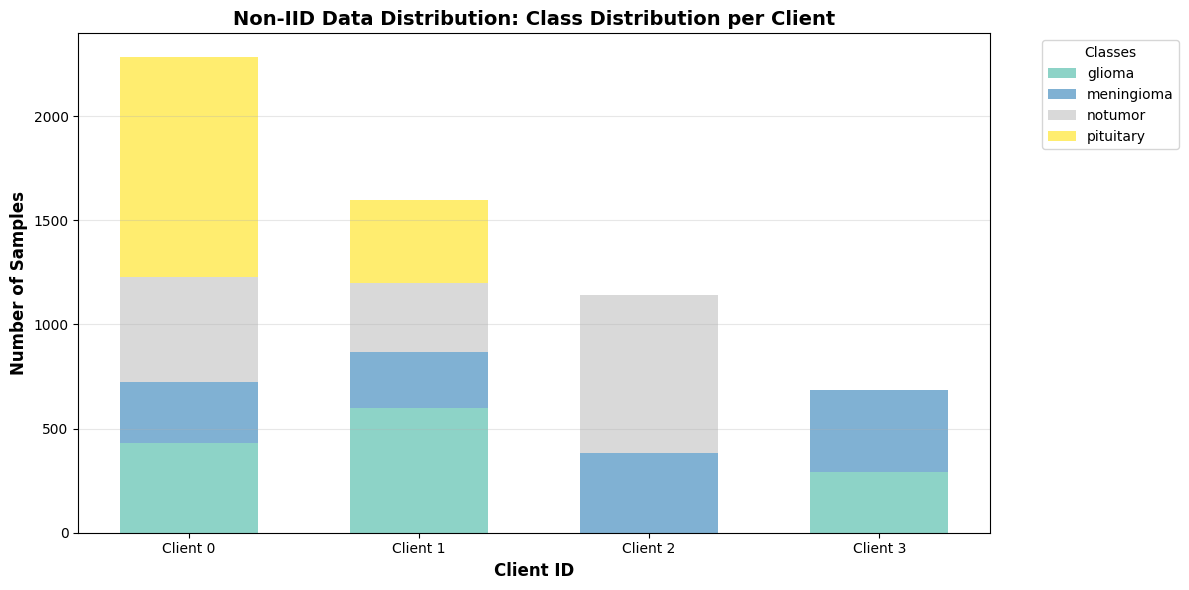

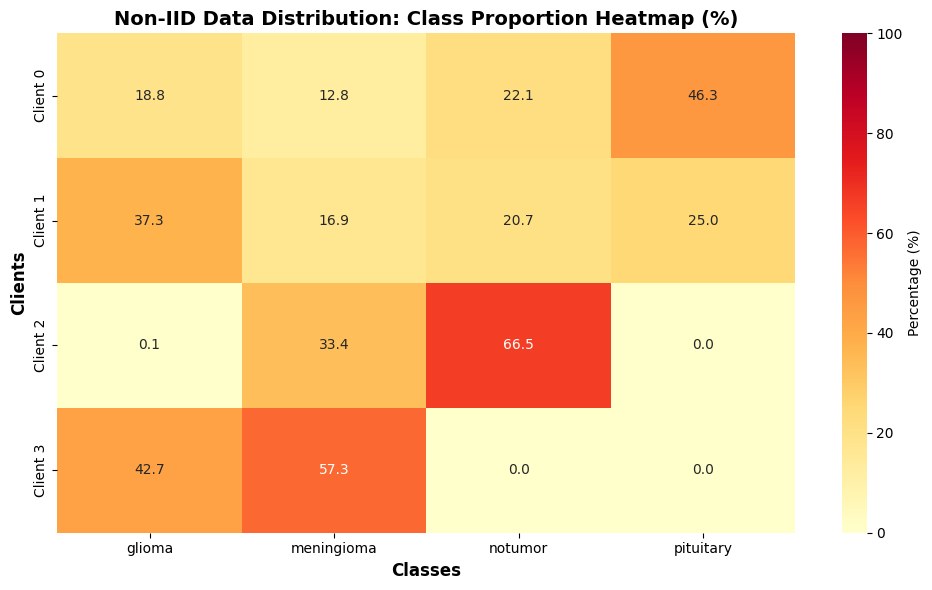

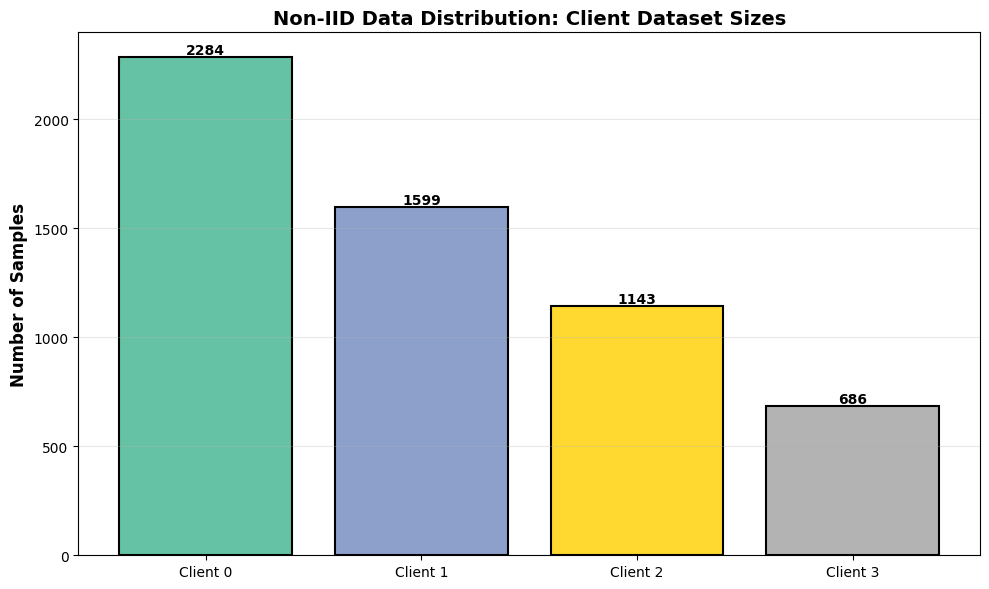

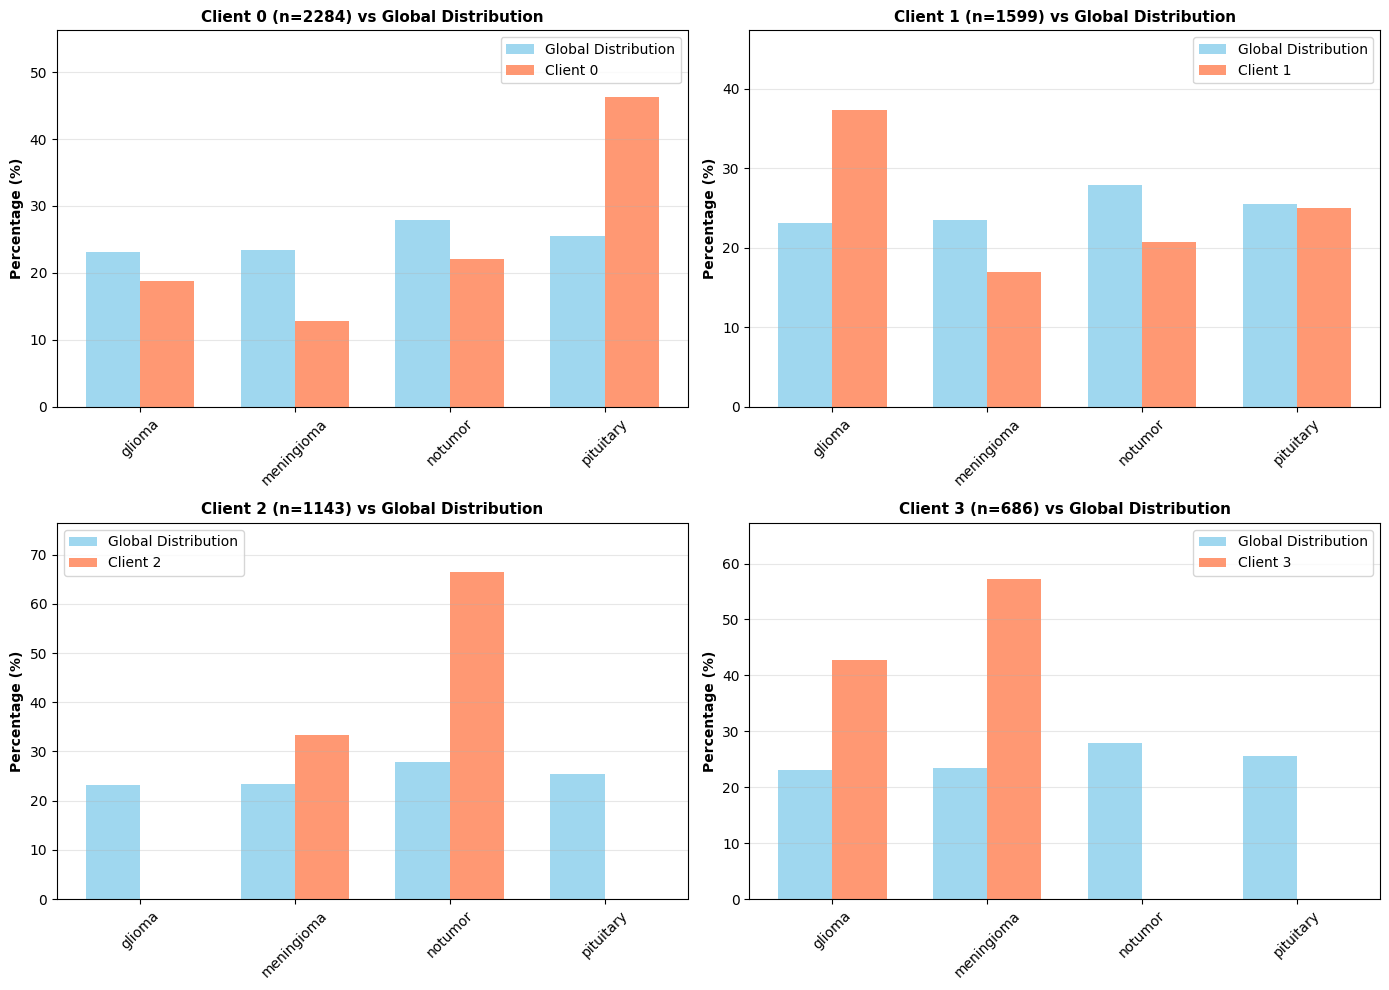


NON-IID DATA DISTRIBUTION SUMMARY

Client 0: 2284 samples
  glioma: 430 (18.8%)
  meningioma: 293 (12.8%)
  notumor: 504 (22.1%)
  pituitary: 1057 (46.3%)

Client 1: 1599 samples
  glioma: 597 (37.3%)
  meningioma: 271 (16.9%)
  notumor: 331 (20.7%)
  pituitary: 400 (25.0%)

Client 2: 1143 samples
  glioma: 1 (0.1%)
  meningioma: 382 (33.4%)
  notumor: 760 (66.5%)
  pituitary: 0 (0.0%)

Client 3: 686 samples
  glioma: 293 (42.7%)
  meningioma: 393 (57.3%)
  notumor: 0 (0.0%)
  pituitary: 0 (0.0%)

Global Distribution (Overall):
  glioma: 1321 (23.1%)
  meningioma: 1339 (23.4%)
  notumor: 1595 (27.9%)
  pituitary: 1457 (25.5%)


In [126]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import seaborn as sns

# ----- 1. Extract class distribution per client -----
client_class_dist = {}
for k, idxs in client_indices.items():
    per_class = defaultdict(int)
    for i in idxs:
        per_class[train_full.samples[i][1]] += 1
    client_class_dist[k] = dict(per_class)

# ----- 2. Create stacked bar chart (Class distribution per client) -----
fig, ax = plt.subplots(figsize=(12, 6))

classes = train_full.classes
num_classes = len(classes)
clients = sorted(client_class_dist.keys())

# Prepare data for stacked bar chart
x = np.arange(len(clients))
width = 0.6
colors = plt.cm.Set3(np.linspace(0, 1, num_classes))

bottom = np.zeros(len(clients))
for class_idx, class_name in enumerate(classes):
    counts = [client_class_dist[k].get(class_idx, 0) for k in clients]
    ax.bar(x, counts, width, label=class_name, bottom=bottom, color=colors[class_idx])
    bottom += np.array(counts)

ax.set_xlabel("Client ID", fontsize=12, fontweight='bold')
ax.set_ylabel("Number of Samples", fontsize=12, fontweight='bold')
ax.set_title("Non-IID Data Distribution: Class Distribution per Client", fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f"Client {k}" for k in clients])
ax.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig("non_iid_stacked_bar.png", dpi=300, bbox_inches='tight')
plt.show()

# ----- 3. Create heatmap of class proportions -----
fig, ax = plt.subplots(figsize=(10, 6))

# Create matrix: rows = clients, cols = classes
heatmap_data = []
for k in clients:
    row = [client_class_dist[k].get(class_idx, 0) for class_idx in range(num_classes)]
    # Normalize by client size to show proportions
    total = sum(row)
    row = [x / total * 100 if total > 0 else 0 for x in row]  # convert to percentage
    heatmap_data.append(row)

heatmap_data = np.array(heatmap_data)

# Plot heatmap
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='YlOrRd', cbar_kws={'label': 'Percentage (%)'},
            xticklabels=classes, yticklabels=[f"Client {k}" for k in clients], ax=ax, vmin=0, vmax=100)
ax.set_title("Non-IID Data Distribution: Class Proportion Heatmap (%)", fontsize=14, fontweight='bold')
ax.set_xlabel("Classes", fontsize=12, fontweight='bold')
ax.set_ylabel("Clients", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig("non_iid_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

# ----- 4. Box plot of client sizes -----
fig, ax = plt.subplots(figsize=(10, 6))

client_sizes = [len(client_indices[k]) for k in clients]
colors_box = plt.cm.Set2(np.linspace(0, 1, len(clients)))

bars = ax.bar([f"Client {k}" for k in clients], client_sizes, color=colors_box, edgecolor='black', linewidth=1.5)
ax.set_ylabel("Number of Samples", fontsize=12, fontweight='bold')
ax.set_title("Non-IID Data Distribution: Client Dataset Sizes", fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig("non_iid_client_sizes.png", dpi=300, bbox_inches='tight')
plt.show()

# ----- 5. Comparison: Expected vs Actual class distribution -----
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Global class distribution
global_dist = defaultdict(int)
for i in range(len(train_full)):
    global_dist[train_full.samples[i][1]] += 1

global_percentages = np.array([global_dist[class_idx] / len(train_full) * 100 
                               for class_idx in range(num_classes)])

for idx, k in enumerate(clients):
    ax = axes[idx]
    
    # Client distribution
    client_total = len(client_indices[k])
    client_percentages = np.array([client_class_dist[k].get(class_idx, 0) / client_total * 100 
                                  for class_idx in range(num_classes)])
    
    x_pos = np.arange(num_classes)
    width = 0.35
    
    ax.bar(x_pos - width/2, global_percentages, width, label='Global Distribution', alpha=0.8, color='skyblue')
    ax.bar(x_pos + width/2, client_percentages, width, label=f'Client {k}', alpha=0.8, color='coral')
    
    ax.set_ylabel('Percentage (%)', fontsize=10, fontweight='bold')
    ax.set_title(f'Client {k} (n={client_total}) vs Global Distribution', fontsize=11, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(classes, rotation=45)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, max(global_percentages.max(), client_percentages.max()) + 10])

plt.tight_layout()
plt.savefig("non_iid_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# ----- 6. Summary statistics -----
print("\n" + "="*60)
print("NON-IID DATA DISTRIBUTION SUMMARY")
print("="*60)
for k in clients:
    client_total = len(client_indices[k])
    print(f"\nClient {k}: {client_total} samples")
    for class_idx, class_name in enumerate(classes):
        count = client_class_dist[k].get(class_idx, 0)
        pct = (count / client_total * 100) if client_total > 0 else 0
        print(f"  {class_name}: {count} ({pct:.1f}%)")

print("\n" + "="*60)
print("Global Distribution (Overall):")
print("="*60)
total_samples = len(train_full)
for class_idx, class_name in enumerate(classes):
    count = global_dist[class_idx]
    pct = (count / total_samples * 100)
    print(f"  {class_name}: {count} ({pct:.1f}%)")
print("="*60)


# Divergence amongst clients

Global Distribution: [0.23126751 0.23441877 0.27923669 0.25507703]
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']

JENSEN-SHANNON DIVERGENCE (JS Divergence)
Range: 0 (identical) to 1 (completely different)

Client 0: JS Divergence = 0.1611
Client 1: JS Divergence = 0.1173
Client 2: JS Divergence = 0.4593
Client 3: JS Divergence = 0.4864

Average JS Divergence: 0.3060

KL DIVERGENCE (Kullback-Leibler)
Range: 0 (identical) to ∞ (completely different)

Client 0: KL Divergence = 0.1027
Client 1: KL Divergence = 0.0538
Client 2: KL Divergence = inf
Client 3: KL Divergence = inf

Average KL Divergence: inf

WASSERSTEIN DISTANCE (Earth Mover Distance)
Range: 0 (identical) to any positive value

Client 0: Wasserstein Distance = 0.0918
Client 1: Wasserstein Distance = 0.0471
Client 2: Wasserstein Distance = 0.2324
Client 3: Wasserstein Distance = 0.2328

Average Wasserstein Distance: 0.1510

HELLINGER DISTANCE
Range: 0 (identical) to 1 (completely different)

Client 0: Hellinger Dist

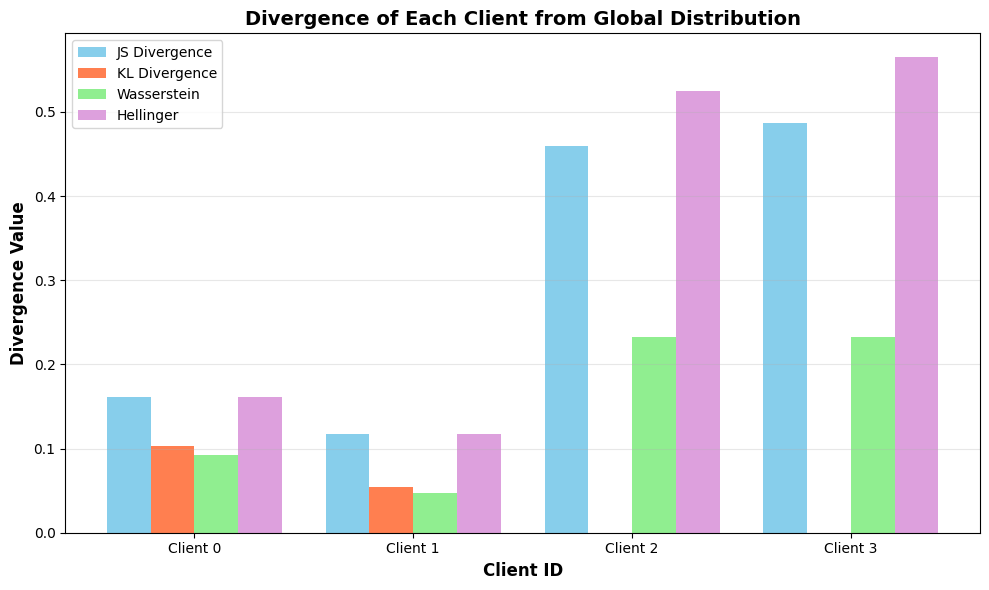

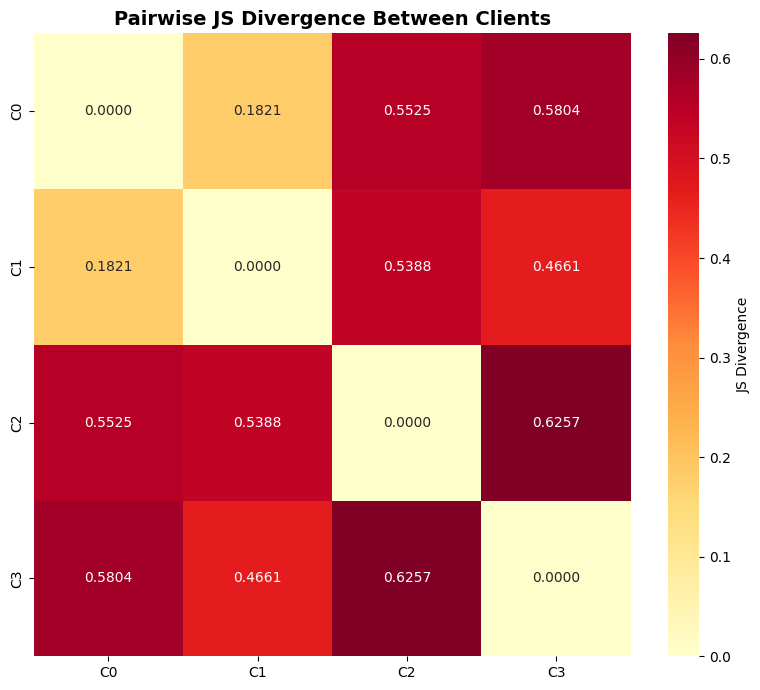

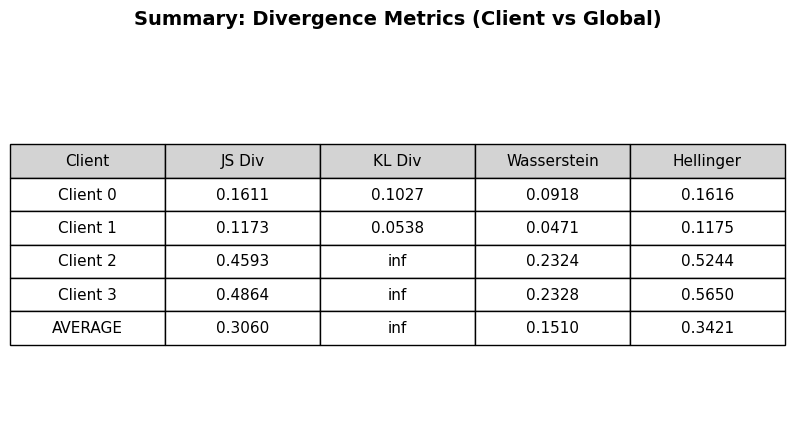


SUMMARY: DIVERGENCE METRICS
Average JS Divergence:        0.3060
Average KL Divergence:        inf
Average Wasserstein Distance: 0.1510
Average Hellinger Distance:   0.3421

Interpretation:
  - Higher values = More divergence = More non-IID
  - Lower values = Less divergence = More IID


  Client  JS_Divergence  KL_Divergence  Wasserstein_Distance  Hellinger_Distance
Client 0       0.161072       0.102686              0.091774            0.161609
Client 1       0.117272       0.053819              0.047061            0.117488
Client 2       0.459285            inf              0.232406            0.524386
Client 3       0.486377            inf              0.232843            0.565020
 Average       0.306001            inf              0.151021            0.342126

✅ Saved to: divergence_metrics.csv


In [127]:
import numpy as np
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy
import matplotlib.pyplot as plt
import pandas as pd

# ----- 1. Prepare class distributions -----
# Extract class distributions for each client
client_distributions = {}
for k in range(NUM_CLIENTS):
    idxs = client_indices[k]
    per_class = np.zeros(len(train_full.classes))
    for i in idxs:
        class_idx = train_full.samples[i][1]
        per_class[class_idx] += 1
    # Normalize to probabilities
    client_distributions[k] = per_class / per_class.sum()

# Global distribution
global_dist = np.zeros(len(train_full.classes))
for i in range(len(train_full)):
    class_idx = train_full.samples[i][1]
    global_dist[class_idx] += 1
global_dist = global_dist / global_dist.sum()

print("Global Distribution:", global_dist)
print("Classes:", train_full.classes)

# ----- 2. Compute divergence metrics -----

# A) Jensen-Shannon Divergence (JS Divergence) - RECOMMENDED
print("\n" + "="*70)
print("JENSEN-SHANNON DIVERGENCE (JS Divergence)")
print("="*70)
print("Range: 0 (identical) to 1 (completely different)")
print()

js_divergences = {}
for k in range(NUM_CLIENTS):
    js_div = jensenshannon(global_dist, client_distributions[k])
    js_divergences[k] = js_div
    print(f"Client {k}: JS Divergence = {js_div:.4f}")

avg_js = np.mean(list(js_divergences.values()))
print(f"\nAverage JS Divergence: {avg_js:.4f}")

# B) KL Divergence (Kullback-Leibler)
print("\n" + "="*70)
print("KL DIVERGENCE (Kullback-Leibler)")
print("="*70)
print("Range: 0 (identical) to ∞ (completely different)")
print()

kl_divergences = {}
for k in range(NUM_CLIENTS):
    kl_div = entropy(global_dist, client_distributions[k])
    kl_divergences[k] = kl_div
    print(f"Client {k}: KL Divergence = {kl_div:.4f}")

avg_kl = np.mean(list(kl_divergences.values()))
print(f"\nAverage KL Divergence: {avg_kl:.4f}")

# C) Wasserstein Distance (Earth Mover Distance)
from scipy.stats import wasserstein_distance
print("\n" + "="*70)
print("WASSERSTEIN DISTANCE (Earth Mover Distance)")
print("="*70)
print("Range: 0 (identical) to any positive value")
print()

wasserstein_dists = {}
for k in range(NUM_CLIENTS):
    w_dist = wasserstein_distance(global_dist, client_distributions[k])
    wasserstein_dists[k] = w_dist
    print(f"Client {k}: Wasserstein Distance = {w_dist:.4f}")

avg_wasserstein = np.mean(list(wasserstein_dists.values()))
print(f"\nAverage Wasserstein Distance: {avg_wasserstein:.4f}")

# D) Hellinger Distance
print("\n" + "="*70)
print("HELLINGER DISTANCE")
print("="*70)
print("Range: 0 (identical) to 1 (completely different)")
print()

def hellinger_distance(p, q):
    return np.sqrt(0.5 * np.sum((np.sqrt(p) - np.sqrt(q))**2))

hellinger_dists = {}
for k in range(NUM_CLIENTS):
    h_dist = hellinger_distance(global_dist, client_distributions[k])
    hellinger_dists[k] = h_dist
    print(f"Client {k}: Hellinger Distance = {h_dist:.4f}")

avg_hellinger = np.mean(list(hellinger_dists.values()))
print(f"\nAverage Hellinger Distance: {avg_hellinger:.4f}")

# ----- 3. Pairwise divergence between clients (Client-to-Client) -----
print("\n" + "="*70)
print("PAIRWISE CLIENT-TO-CLIENT JS DIVERGENCE")
print("="*70)
print()

pairwise_js = np.zeros((NUM_CLIENTS, NUM_CLIENTS))
for i in range(NUM_CLIENTS):
    for j in range(i+1, NUM_CLIENTS):
        js_ij = jensenshannon(client_distributions[i], client_distributions[j])
        pairwise_js[i, j] = js_ij
        pairwise_js[j, i] = js_ij
        print(f"Client {i} vs Client {j}: JS = {js_ij:.4f}")

# ----- 4. Visualizations -----

# Plot 1: Divergence from Global (Bar Chart)
fig, ax = plt.subplots(figsize=(10, 6))
clients = list(range(NUM_CLIENTS))
colors = plt.cm.Set2(np.linspace(0, 1, NUM_CLIENTS))

x = np.arange(len(clients))
width = 0.2

bars1 = ax.bar(x - 1.5*width, list(js_divergences.values()), width, label='JS Divergence', color='skyblue')
bars2 = ax.bar(x - 0.5*width, list(kl_divergences.values()), width, label='KL Divergence', color='coral')
bars3 = ax.bar(x + 0.5*width, list(wasserstein_dists.values()), width, label='Wasserstein', color='lightgreen')
bars4 = ax.bar(x + 1.5*width, list(hellinger_dists.values()), width, label='Hellinger', color='plum')

ax.set_xlabel('Client ID', fontsize=12, fontweight='bold')
ax.set_ylabel('Divergence Value', fontsize=12, fontweight='bold')
ax.set_title('Divergence of Each Client from Global Distribution', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'Client {k}' for k in clients])
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('divergence_from_global.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: Pairwise JS Divergence Heatmap (Client-to-Client)
fig, ax = plt.subplots(figsize=(8, 7))
import seaborn as sns
sns.heatmap(pairwise_js, annot=True, fmt='.4f', cmap='YlOrRd', 
            xticklabels=[f'C{k}' for k in clients],
            yticklabels=[f'C{k}' for k in clients],
            ax=ax, cbar_kws={'label': 'JS Divergence'})
ax.set_title('Pairwise JS Divergence Between Clients', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('pairwise_divergence_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 3: Summary Statistics Table
fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('tight')
ax.axis('off')

summary_data = []
for k in range(NUM_CLIENTS):
    summary_data.append([
        f'Client {k}',
        f'{js_divergences[k]:.4f}',
        f'{kl_divergences[k]:.4f}',
        f'{wasserstein_dists[k]:.4f}',
        f'{hellinger_dists[k]:.4f}'
    ])

# Add average row
summary_data.append([
    'AVERAGE',
    f'{avg_js:.4f}',
    f'{avg_kl:.4f}',
    f'{avg_wasserstein:.4f}',
    f'{avg_hellinger:.4f}'
])

table = ax.table(cellText=summary_data,
                colLabels=['Client', 'JS Div', 'KL Div', 'Wasserstein', 'Hellinger'],
                cellLoc='center',
                loc='center',
                colColours=['lightgray']*5)
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)

plt.title('Summary: Divergence Metrics (Client vs Global)', fontsize=14, fontweight='bold', pad=20)
plt.savefig('divergence_summary_table.png', dpi=300, bbox_inches='tight')
plt.show()

# ----- 5. Print Summary -----
print("\n" + "="*70)
print("SUMMARY: DIVERGENCE METRICS")
print("="*70)
print(f"Average JS Divergence:        {avg_js:.4f}")
print(f"Average KL Divergence:        {avg_kl:.4f}")
print(f"Average Wasserstein Distance: {avg_wasserstein:.4f}")
print(f"Average Hellinger Distance:   {avg_hellinger:.4f}")
print("\nInterpretation:")
print("  - Higher values = More divergence = More non-IID")
print("  - Lower values = Less divergence = More IID")
print("="*70)

# ----- 6. Create DataFrame for export -----
divergence_df = pd.DataFrame({
    'Client': [f'Client {k}' for k in range(NUM_CLIENTS)] + ['Average'],
    'JS_Divergence': list(js_divergences.values()) + [avg_js],
    'KL_Divergence': list(kl_divergences.values()) + [avg_kl],
    'Wasserstein_Distance': list(wasserstein_dists.values()) + [avg_wasserstein],
    'Hellinger_Distance': list(hellinger_dists.values()) + [avg_hellinger],
})

print("\n")
print(divergence_df.to_string(index=False))

# Save to CSV
divergence_df.to_csv('divergence_metrics.csv', index=False)
print("\n✅ Saved to: divergence_metrics.csv")


# Explanation of Image Transforms in PyTorch

- `train_tf`: This is a composition of transformations applied to training images to augment and preprocess them before feeding into the model:
  - `Resize((224, 224))`: Resize all images to 224x224 pixels.
  - `RandomHorizontalFlip(p=0.5)`: Flip images horizontally with 50% probability to augment data.
  - `RandomRotation(10)`: Rotate images randomly by up to ±10 degrees for more variety.
  - `ColorJitter(brightness=0.1, contrast=0.1)`: Slightly change brightness and contrast randomly.
  - `RandomResizedCrop(224, scale=(0.85,1.0))`: Randomly crop and resize images to 224x224 with a scale between 85% to 100% of the original size.
  - `ToTensor()`: Convert images from PIL format (0-255 pixels) to a PyTorch tensor (0.0 to 1.0) format.
  - `Normalize(mean, std)`: Normalize image pixel values channel-wise using ImageNet statistics to standardize inputs.

- `eval_tf`: Simpler transform pipeline for validation or testing images without augmentation to ensure consistent evaluation:
  - Just resize to 224x224, convert to tensor, and normalize with the same mean and std as training.

These transforms help improve model robustness by augmenting training data, while keeping evaluation data consistent for fair performance measurement.


In [27]:
# 6) Datasets & DataLoaders (reproducible)

from torch.utils.data import DataLoader, Subset
from torchvision import datasets

# Re-instantiate datasets with transforms
train_full_tf = datasets.ImageFolder(TRAIN_DIR, transform=train_tf)
holdout_tf    = datasets.ImageFolder(TEST_DIR,  transform=eval_tf)

BATCH_SIZE = 32  # or your chosen batch size

# --- Reproducible DataLoader RNG (add before creating any DataLoader) ---
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

def make_generator(seed):
    g = torch.Generator()
    g.manual_seed(seed)
    return g

client_loaders = {}

# Build per-client loaders (train with augmentation, local test without)
for k in range(NUM_CLIENTS):
    tr_idx = client_splits[k]["train"]
    te_idx = client_splits[k]["test"]

    # Subsets: training uses augmented transform; local test uses eval transform
    ds_tr = Subset(train_full_tf, tr_idx)
    ds_te = Subset(datasets.ImageFolder(TRAIN_DIR, transform=eval_tf), te_idx)

    # Unique, reproducible generator per client
    gen_k = make_generator(SEED + k)

    train_loader = DataLoader(
        ds_tr,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=0,
        pin_memory=True,
        worker_init_fn=seed_worker,
        generator=gen_k,
    )

    test_loader = DataLoader(
        ds_te,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
        worker_init_fn=seed_worker,
        generator=gen_k,
    )

    client_loaders[k] = {
        "train": train_loader,
        "test":  test_loader,
        "sizes": (len(ds_tr), len(ds_te)),
    }

# Global holdout loader (deterministic as well)
holdout_loader = DataLoader(
    holdout_tf,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    worker_init_fn=seed_worker,
    generator=make_generator(SEED + 10_000),
)

print("Global holdout batches:", len(holdout_loader))
for k, v in client_loaders.items():
    print(f"Client {k}: train={v['sizes'][0]} | local_test={v['sizes'][1]}")


Global holdout batches: 41
Client 0: train=1827 | local_test=457
Client 1: train=1279 | local_test=320
Client 2: train=914 | local_test=229
Client 3: train=548 | local_test=138


# Explanation of Dataset and DataLoader Setup for Federated Learning

1. **Datasets with Transforms**:  
   - `train_full_tf` and `holdout_tf` are the full training and holdout datasets re-instantiated with data transformations (augmentation for training, evaluation transform for holdout).

2. **Reproducible DataLoader Randomness**:  
   To ensure consistent data shuffling and batching across runs, even in multi-worker loading, the code defines:
   - `seed_worker(worker_id)`: seeds each worker’s RNG using PyTorch’s initial seed.
   - `make_generator(seed)`: creates a PyTorch random number generator with a manual seed for deterministic shuffling.

3. **Client-specific DataLoaders**:  
   For each federated client (client ID `k`):
   - Subsets of training and testing data specific to the client (`tr_idx` and `te_idx`) are created using `Subset`.
   - Training subsets use augmented training transforms; local test subsets use evaluation transforms.
   - Unique and reproducible random generators seeded with `SEED + k` ensure each client’s data shuffling stays the same across experiments.
   - `DataLoader`s are created for training (with shuffling) and testing (without shuffling) with batch size `BATCH_SIZE`.
   - These loaders are stored in `client_loaders[k]` as a dictionary containing train loader, test loader, and dataset sizes.

4. **Global Holdout DataLoader**:  
   - A separate DataLoader is created for the global holdout test set with evaluation transforms, no shuffling, and seeded RNG for determinism.

5. **Printed Summary**:  
   - The total number of batches in the global holdout loader.  
   - Train and local test sizes per client showing data splits.

This setup provides a reproducible, federated data pipeline with augmented training data, separate local tests for each client, and a final unseen global holdout for evaluation. The use of seeded RNGs and `Subset` ensures exact and controlled data partitions across multiple runs or experiments.


In [28]:
# 7) Persist split (so you can resume with exactly the same heterogeneity)
split_path = os.path.join(ROOT, f"client_split_seed{SEED}.json")
with open(split_path, "w") as f:
    json.dump(client_splits, f)
print("Saved split to:", split_path)


Saved split to: cleaned/client_split_seed77.json


✅ What below Code Does (Simple Explanation)

This code performs local training of ResNet-18 models on multiple clients (like in Federated Learning), especially when their data is non-IID (not evenly distributed).

For each client:

A fresh ResNet-18 is created with optional ImageNet weights.

The feature extractor part (base model) is frozen (i.e., only the final classification layer is trained at first).

After a couple of epochs, the full model is optionally unfrozen for fine-tuning.

AMP (Automatic Mixed Precision) is used to speed up GPU training.

Each client trains locally and stores:

Final accuracy and loss

The model's parameters (state_dict)

No federated averaging (FedAvg) yet — this is just local training per client.

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import os

# Automatically create a folder to store best models
SAVE_DIR = "./client_models"
os.makedirs(SAVE_DIR, exist_ok=True)


# ============ Setup ============
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
crit_ce = nn.CrossEntropyLoss()

# Example: define NUM_CLASSES and NUM_CLIENTS (must be set properly)
NUM_CLASSES = len(train_full.classes)
NUM_CLIENTS = len(client_loaders)

# ============ Model Creation Function ============
def create_resnet18(num_classes, imagenet_init=True, freeze=True):
    if imagenet_init:
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    else:
        model = models.resnet18(weights=None)
    
    # Replace final fully connected layer
    in_f = model.fc.in_features
    model.fc = nn.Linear(in_f, num_classes)
    
    # Freeze all layers except the final classifier (if freeze=True)
    if freeze:
        for name, param in model.named_parameters():
            if "fc" not in name:
                param.requires_grad = False
    return model

# ============ Evaluation ============
@torch.no_grad()
def evaluate_basic(model, loader, device, amp=False):
    model.eval()
    total_loss, total_correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        if amp:
            with torch.cuda.amp.autocast():
                logits = model(x)
                loss = crit_ce(logits, y)
        else:
            logits = model(x)
            loss = crit_ce(logits, y)
        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)
    return {
        "loss": total_loss / max(total, 1),
        "acc": total_correct / max(total, 1)
    }

# ============ Training (one epoch) ============
def train_one_epoch(model, loader, device, optimizer, scaler=None, amp=True):
    model.train()
    total_loss, total_correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        if scaler:
            with torch.cuda.amp.autocast():
                logits = model(x)
                loss = crit_ce(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(x)
            loss = crit_ce(logits, y)
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)
    return {
        "loss": total_loss / max(total, 1),
        "acc": total_correct / max(total, 1)
    }

# ============ Main Training Loop Per Client ============
LOCAL_EPOCHS = 4
LR = 1e-3
WD = 1e-4
imagenet_init = True
freeze_base = True  # Start with frozen base (feature extraction)
UNFREEZE_AT_EPOCH = 2  # Unfreeze at this epoch for fine-tuning

local_results = {}

for k in range(NUM_CLIENTS):
    print(f"\n===== Client {k} — Local ResNet Training =====")

    freeze_base = True  # ✅ reset for each client

    model = create_resnet18(NUM_CLASSES, imagenet_init=imagenet_init, freeze=freeze_base).to(DEVICE)

    # Define optimizer and scaler outside training loop
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.Adam(params, lr=LR, weight_decay=WD)
    scaler = torch.cuda.amp.GradScaler() if DEVICE.type == "cuda" else None

    # -------------------------------
    # Track best model per client
    # -------------------------------
    best_acc = -1.0
    best_model_state = None
    best_metrics = None

    # ==========================
    # ✅ Local training epochs
    # ==========================
    for ep in range(1, LOCAL_EPOCHS + 1):
        # Optional: unfreeze the model for fine-tuning
        if ep == UNFREEZE_AT_EPOCH and freeze_base:
            print(f"Epoch {ep}: Unfreezing base model for fine-tuning...")
            for param in model.parameters():
                param.requires_grad = True
            freeze_base = False  # ✅ only unfreeze once
            optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WD)

        # Train + evaluate
        tr = train_one_epoch(model, client_loaders[k]["train"], DEVICE, optimizer, scaler=scaler, amp=True)
        te = evaluate_basic(model, client_loaders[k]["test"], DEVICE, amp=True)
        print(f"Epoch {ep:02d} | train: acc={tr['acc']:.3f}, loss={tr['loss']:.4f} | "
              f"test: acc={te['acc']:.3f}, loss={te['loss']:.4f}")
        

        # ✅ Check if this is the best test accuracy so far
        if te["acc"] > best_acc:
            best_acc = te["acc"]
            best_model_state = {n: p.detach().cpu().clone() for n, p in model.state_dict().items()}
            best_metrics = te.copy()


    # Final metrics
    m_train = evaluate_basic(model, client_loaders[k]["train"], DEVICE, amp=True)
    local_results[k] = {
        "final_train": m_train,
        "final_test":  best_metrics,   # ✅ best test metrics
        "state_dict":  best_model_state  # ✅ best weights
    }
    # Save best model to file
    save_path = os.path.join(SAVE_DIR, f"client_{k}_best_model.pth")
    torch.save(best_model_state, save_path)
    print(f"✅ Saved best model for Client {k} to: {save_path}")


print("\n✅ Done: Local ResNet training completed for all clients (best models saved).")


===== Client 0 — Local ResNet Training =====
Epoch 01 | train: acc=0.622, loss=0.9947 | test: acc=0.827, loss=0.6471
Epoch 2: Unfreezing base model for fine-tuning...
Epoch 02 | train: acc=0.825, loss=0.5141 | test: acc=0.904, loss=0.3158
Epoch 03 | train: acc=0.914, loss=0.2475 | test: acc=0.891, loss=0.2701
Epoch 04 | train: acc=0.910, loss=0.2561 | test: acc=0.886, loss=0.3314
✅ Saved best model for Client 0 to: ./client_models/client_0_best_model.pth

===== Client 1 — Local ResNet Training =====
Epoch 01 | train: acc=0.530, loss=1.1128 | test: acc=0.669, loss=0.9189
Epoch 2: Unfreezing base model for fine-tuning...
Epoch 02 | train: acc=0.762, loss=0.6589 | test: acc=0.350, loss=4.3986
Epoch 03 | train: acc=0.859, loss=0.3738 | test: acc=0.666, loss=1.5472
Epoch 04 | train: acc=0.902, loss=0.2749 | test: acc=0.875, loss=0.3715
✅ Saved best model for Client 1 to: ./client_models/client_1_best_model.pth

===== Client 2 — Local ResNet Training =====
Epoch 01 | train: acc=0.811, loss=

## Global model fed avg 

In [38]:
# ===== Step 1: FedAvg Aggregation =====
def average_weights(state_dicts):
    avg_state = {}
    for key in state_dicts[0].keys():
        avg_state[key] = sum(sd[key] for sd in state_dicts) / len(state_dicts)
    return avg_state

# Collect best local models from previous step
local_state_dicts = [local_results[k]["state_dict"] for k in range(NUM_CLIENTS)]

# Average weights to get global model
global_state = average_weights(local_state_dicts)

# Initialize a new global model with same structure
global_model = create_resnet18(NUM_CLASSES, imagenet_init=False, freeze=False).to(DEVICE)
global_model.load_state_dict(global_state)
global_model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Global model on hold out test data

In [71]:
holdout_metrics = evaluate_basic(global_model, holdout_loader, DEVICE, amp=True)
print(f"\n🌍 Global Model on HOLDOUT test set — acc: {holdout_metrics['acc']:.3f}, loss: {holdout_metrics['loss']:.4f}")


/Users/ishabhansali/.venv310/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(



🌍 Global Model on HOLDOUT test set — acc: 0.233, loss: 1.7036


## Global model on local test data (fed avg )

In [67]:
for k in range(NUM_CLIENTS):
    client_metrics = evaluate_basic(global_model, client_loaders[k]["test"], DEVICE, amp=True)
    print(f"📉 Global Model on Client {k}'s local test set — acc: {client_metrics['acc']:.3f}, loss: {client_metrics['loss']:.4f}")


/Users/ishabhansali/.venv310/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


📉 Global Model on Client 0's local test set — acc: 0.125, loss: 2.1390
📉 Global Model on Client 1's local test set — acc: 0.128, loss: 1.9474
📉 Global Model on Client 2's local test set — acc: 0.332, loss: 1.0858
📉 Global Model on Client 3's local test set — acc: 0.565, loss: 1.1522


## Fed prox using global average weights 

In [42]:
def train_fedprox_epoch(model, loader, device, optimizer, global_weights, mu=1e-3, scaler=None, amp=True):
    model.train()
    total_loss, total_correct, total = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        if scaler:
            with torch.cuda.amp.autocast():
                logits = model(x)
                ce_loss = crit_ce(logits, y)

                # ===== FedProx proximal penalty =====
                prox_loss = 0.0
                for name, param in model.named_parameters():
                    if param.requires_grad:
                        prox_loss += ((param - global_weights[name].to(device)) ** 2).sum()
                loss = ce_loss + (mu / 2) * prox_loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(x)
            ce_loss = crit_ce(logits, y)
            prox_loss = 0.0
            for name, param in model.named_parameters():
                if param.requires_grad:
                    prox_loss += ((param - global_weights[name].to(device)) ** 2).sum()
            loss = ce_loss + (mu / 2) * prox_loss
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    return {
        "loss": total_loss / max(total, 1),
        "acc": total_correct / max(total, 1)
    }


## fed prox on local model and local test data

In [44]:
FEDPROX_EPOCHS = 4  # same as FedAvg
MU = 1e-3            # strength of proximal term

prox_results = {}

# Create a frozen copy of global weights (from FedAvg global model)
global_weights = {n: p.detach().clone() for n, p in global_model.state_dict().items()}

for k in range(NUM_CLIENTS):
    print(f"\n===== FedProx: Client {k} Training =====")

    model = create_resnet18(NUM_CLASSES, imagenet_init=False, freeze=False).to(DEVICE)
    model.load_state_dict(global_weights)  # Start from FedAvg global model

    optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
    scaler = torch.cuda.amp.GradScaler() if DEVICE.type == "cuda" else None

    best_acc = -1.0
    best_model_state = None
    best_metrics = None

    for ep in range(1, FEDPROX_EPOCHS + 1):
        tr = train_fedprox_epoch(model, client_loaders[k]["train"], DEVICE, optimizer,
                                 global_weights, mu=MU, scaler=scaler, amp=True)
        te = evaluate_basic(model, client_loaders[k]["test"], DEVICE, amp=True)

        print(f"Epoch {ep:02d} | train: acc={tr['acc']:.3f}, loss={tr['loss']:.4f} | "
              f"test: acc={te['acc']:.3f}, loss={te['loss']:.4f}")

        if te["acc"] > best_acc:
            best_acc = te["acc"]
            best_model_state = {n: p.detach().cpu().clone() for n, p in model.state_dict().items()}
            best_metrics = te.copy()

    prox_results[k] = {
        "final_test": best_metrics,
        "state_dict": best_model_state
    }
    # Save best FedProx model to disk
    save_path = os.path.join(SAVE_DIR, f"client_{k}_fedprox_best_model.pth")
    torch.save(best_model_state, save_path)
    print(f"✅ Saved FedProx best model for Client {k} to: {save_path}")




===== FedProx: Client 0 Training =====
Epoch 01 | train: acc=0.818, loss=0.6995 | test: acc=0.794, loss=0.5784
Epoch 02 | train: acc=0.862, loss=0.6337 | test: acc=0.945, loss=0.1533
Epoch 03 | train: acc=0.918, loss=0.4890 | test: acc=0.895, loss=0.2570
Epoch 04 | train: acc=0.899, loss=0.5016 | test: acc=0.908, loss=0.2570
✅ Saved FedProx best model for Client 0 to: ./client_models/client_0_fedprox_best_model.pth

===== FedProx: Client 1 Training =====
Epoch 01 | train: acc=0.837, loss=0.5735 | test: acc=0.816, loss=1.8282
Epoch 02 | train: acc=0.877, loss=0.5136 | test: acc=0.856, loss=0.3676
Epoch 03 | train: acc=0.922, loss=0.3896 | test: acc=0.766, loss=0.8526
Epoch 04 | train: acc=0.909, loss=0.4283 | test: acc=0.900, loss=0.3724
✅ Saved FedProx best model for Client 1 to: ./client_models/client_1_fedprox_best_model.pth

===== FedProx: Client 2 Training =====
Epoch 01 | train: acc=0.946, loss=0.2230 | test: acc=0.882, loss=0.6075
Epoch 02 | train: acc=0.955, loss=0.2337 | test:

## averaging the fed prox now

In [45]:
# Average client weights (from FedProx)
prox_state_dicts = [prox_results[k]["state_dict"] for k in range(NUM_CLIENTS)]
prox_global_state = average_weights(prox_state_dicts)

# Load into new model
prox_global_model = create_resnet18(NUM_CLASSES, imagenet_init=False, freeze=False).to(DEVICE)
prox_global_model.load_state_dict(prox_global_state)
prox_global_model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [46]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import torch.nn.functional as F

@torch.no_grad()
def evaluate_all_metrics(model, loader, device, amp=True, num_classes=NUM_CLASSES):
    model.eval()
    all_logits = []
    all_targets = []

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        with torch.cuda.amp.autocast(enabled=amp):
            logits = model(x)
        all_logits.append(logits.cpu())
        all_targets.append(y.cpu())

    logits = torch.cat(all_logits)
    targets = torch.cat(all_targets)
    probs = F.softmax(logits, dim=1)
    preds = probs.argmax(dim=1)

    metrics = {
        'acc': (preds == targets).float().mean().item(),
        'precision': precision_score(targets, preds, average='macro', zero_division=0),
        'recall': recall_score(targets, preds, average='macro', zero_division=0),
        'f1': f1_score(targets, preds, average='macro', zero_division=0)
    }

    # AUROC
    try:
        if num_classes == 2:
            metrics['auroc'] = roc_auc_score(targets, probs[:, 1])
        else:
            metrics['auroc'] = roc_auc_score(targets, probs, multi_class='ovr')
    except ValueError:
        metrics['auroc'] = None

    metrics['conf_matrix'] = confusion_matrix(targets, preds)
    return metrics


## fed prox global model and evaluating on holdout test data

In [47]:
metrics = evaluate_all_metrics(prox_global_model, holdout_loader, DEVICE)
print("\n📊 FedProx Global — Holdout Set")
for k, v in metrics.items():
    if k != 'conf_matrix':
        print(f"{k:>10}: {v:.4f}")


/Users/ishabhansali/.venv310/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(



📊 FedProx Global — Holdout Set
       acc: 0.7071
 precision: 0.5872
    recall: 0.6877
        f1: 0.6143
     auroc: 0.9809


## using the same global fed prox and evaluating on each clients local test data and see how performance reduces

In [50]:
for k in range(NUM_CLIENTS):
    metrics = evaluate_all_metrics(prox_global_model, client_loaders[k]["test"], DEVICE)
    print(f"\n🧪 Client {k} | FedProx Global")
    for m, v in metrics.items():
        if m != 'conf_matrix':
            if v is not None:
                print(f"{m:>10}: {v:.4f}")
            else:
                print(f"{m:>10}: None")


/Users/ishabhansali/.venv310/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(



🧪 Client 0 | FedProx Global
       acc: 0.5033
 precision: 0.5275
    recall: 0.7282
        f1: 0.5623
     auroc: 0.9867


/Users/ishabhansali/.venv310/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(



🧪 Client 1 | FedProx Global
       acc: 0.7063
 precision: 0.5624
    recall: 0.6933
        f1: 0.5843
     auroc: 0.9812


/Users/ishabhansali/.venv310/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(



🧪 Client 2 | FedProx Global
       acc: 0.9432
 precision: 0.7879
    recall: 0.9715
        f1: 0.8496
     auroc: None


/Users/ishabhansali/.venv310/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(



🧪 Client 3 | FedProx Global
       acc: 0.9638
 precision: 0.6580
    recall: 0.6427
        f1: 0.6503
     auroc: None


In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(cm, class_names, title="Confusion Matrix"):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.tight_layout()
    plt.show()


/Users/ishabhansali/.venv310/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


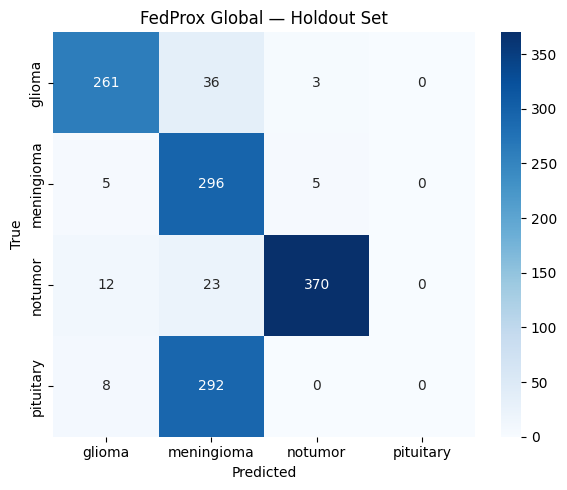

In [52]:
# Evaluate and plot confusion matrix for holdout
metrics = evaluate_all_metrics(prox_global_model, holdout_loader, DEVICE)
cm = metrics['conf_matrix']
plot_confusion_matrix(cm, class_names=train_full.classes, title="FedProx Global — Holdout Set")


/Users/ishabhansali/.venv310/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


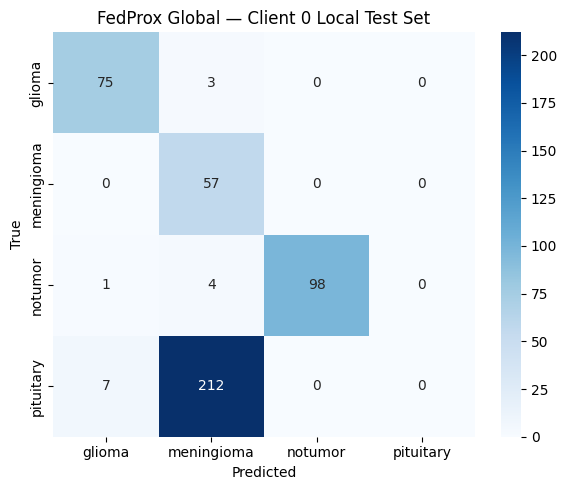

/Users/ishabhansali/.venv310/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


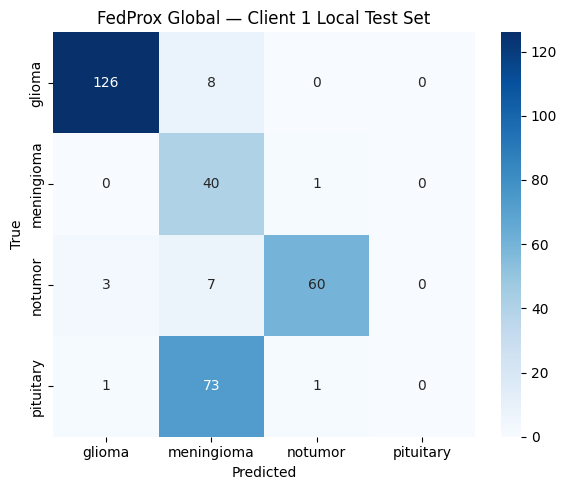

/Users/ishabhansali/.venv310/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


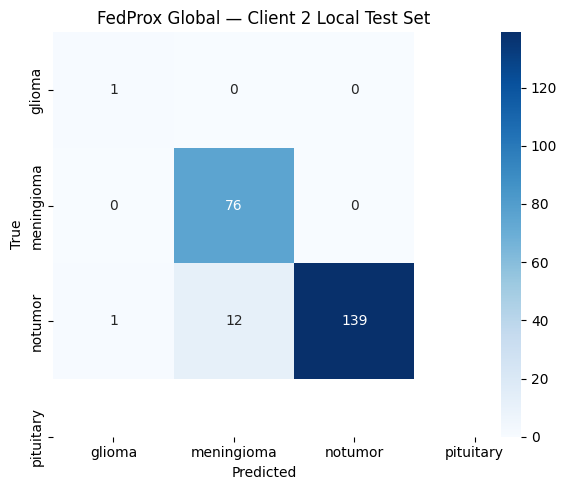

/Users/ishabhansali/.venv310/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


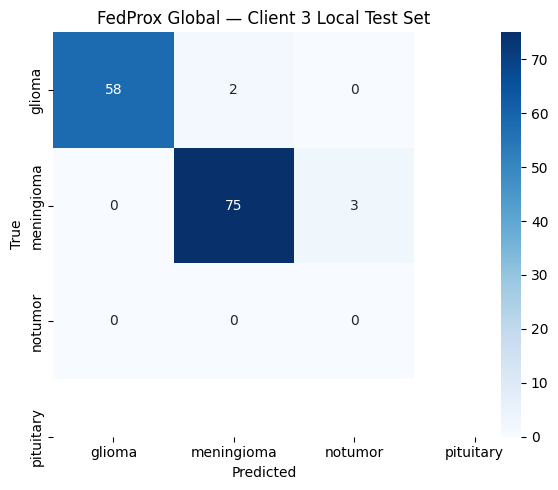

In [53]:
for k in range(NUM_CLIENTS):
    metrics = evaluate_all_metrics(prox_global_model, client_loaders[k]["test"], DEVICE)
    cm = metrics['conf_matrix']
    plot_confusion_matrix(cm, class_names=train_full.classes,
                          title=f"FedProx Global — Client {k} Local Test Set")


## fed average global model evaluations

In [54]:
# Average the local models from FedAvg phase
fedavg_state_dicts = [local_results[k]["state_dict"] for k in range(NUM_CLIENTS)]
fedavg_global_state = average_weights(fedavg_state_dicts)

# Create and load model
fedavg_global_model = create_resnet18(NUM_CLASSES, imagenet_init=False, freeze=False).to(DEVICE)
fedavg_global_model.load_state_dict(fedavg_global_state)
fedavg_global_model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/Users/ishabhansali/.venv310/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(



📊 FedAvg Global — Holdout Set
       acc: 0.2334
 precision: 0.0584
    recall: 0.2500
        f1: 0.0946
     auroc: 0.8338


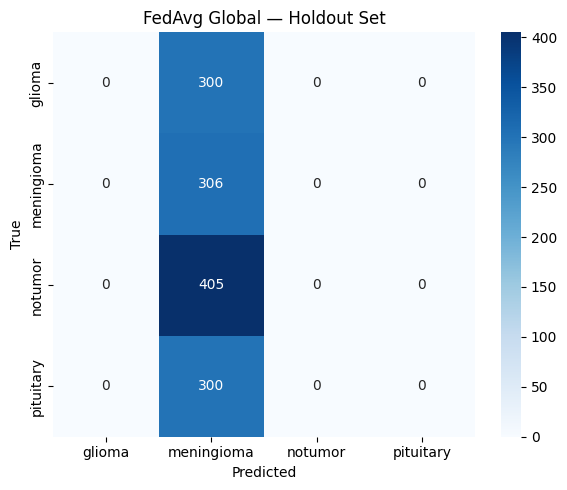

In [55]:
metrics = evaluate_all_metrics(fedavg_global_model, holdout_loader, DEVICE)
print("\n📊 FedAvg Global — Holdout Set")
for k, v in metrics.items():
    if k != 'conf_matrix':
        print(f"{k:>10}: {v:.4f}")

# Plot confusion matrix
plot_confusion_matrix(metrics['conf_matrix'], class_names=train_full.classes,
                      title="FedAvg Global — Holdout Set")


/Users/ishabhansali/.venv310/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(



🧪 Client 0 | FedAvg Global
       acc: 0.1247
 precision: 0.0312
    recall: 0.2500
        f1: 0.0554
     auroc: 0.8456


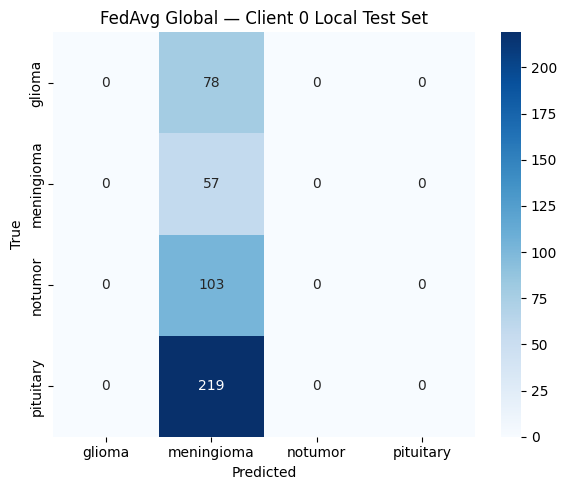

/Users/ishabhansali/.venv310/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(



🧪 Client 1 | FedAvg Global
       acc: 0.1281
 precision: 0.0320
    recall: 0.2500
        f1: 0.0568
     auroc: 0.8681


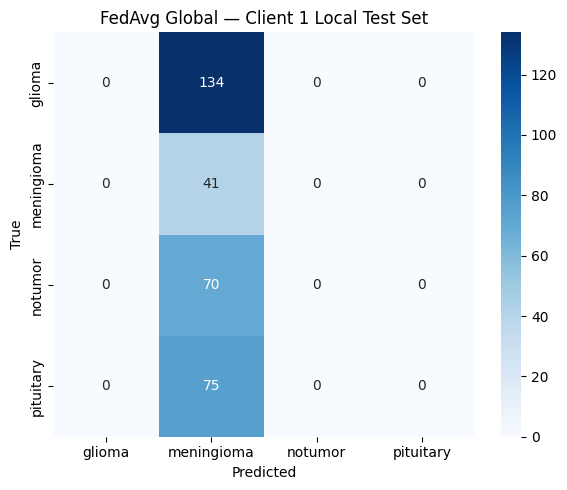

/Users/ishabhansali/.venv310/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(



🧪 Client 2 | FedAvg Global
       acc: 0.3319
 precision: 0.1106
    recall: 0.3333
        f1: 0.1661
     auroc: None


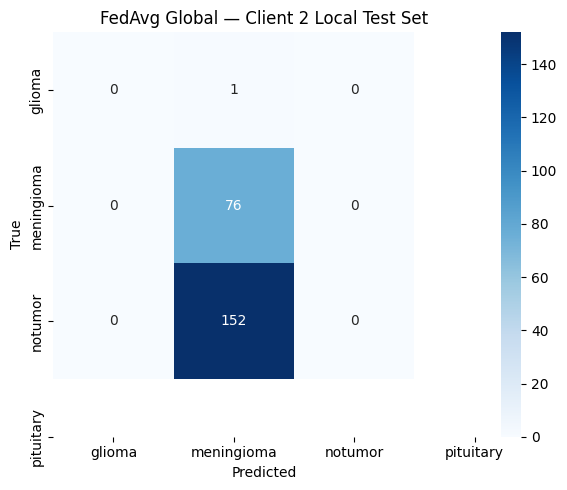

/Users/ishabhansali/.venv310/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(



🧪 Client 3 | FedAvg Global
       acc: 0.5652
 precision: 0.2826
    recall: 0.5000
        f1: 0.3611
     auroc: None


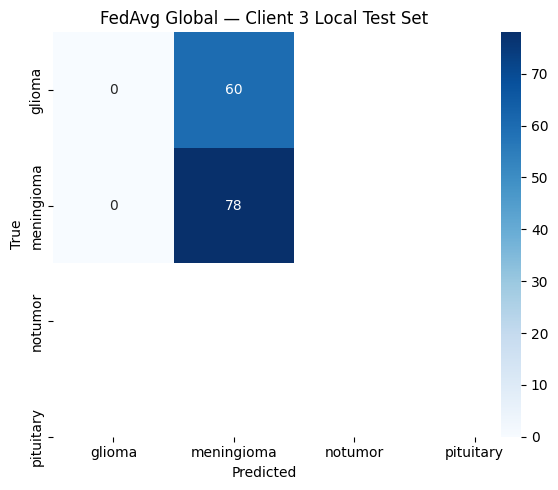

In [57]:
for k in range(NUM_CLIENTS):
    metrics = evaluate_all_metrics(fedavg_global_model, client_loaders[k]["test"], DEVICE)
    print(f"\n🧪 Client {k} | FedAvg Global")
    for m, v in metrics.items():
        if m != 'conf_matrix':
            if v is not None:
                print(f"{m:>10}: {v:.4f}")
            else:
                print(f"{m:>10}: None")

    plot_confusion_matrix(metrics['conf_matrix'], class_names=train_full.classes,
                          title=f"FedAvg Global — Client {k} Local Test Set")


fedavg_global_local_metrics = {}

for k in range(NUM_CLIENTS):
    metrics = evaluate_all_metrics(fedavg_global_model, client_loaders[k]["test"], DEVICE)
    fedavg_global_local_metrics[k] = {
        "acc": metrics["acc"],
        "precision": metrics["precision"],
        "recall": metrics["recall"],
        "f1": metrics["f1"]
    }

    # Optional: plot confusion matrix
    plot_confusion_matrix(metrics['conf_matrix'], class_names=train_full.classes,
                          title=f"FedAvg Global — Client {k} Local Test Set")


In [61]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def compute_metrics(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = logits.argmax(1)
            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    y_true = torch.cat(all_labels).numpy()
    y_pred = torch.cat(all_preds).numpy()

    return {
        "acc": (y_pred == y_true).mean(),
        "precision": precision_score(y_true, y_pred, average='macro', zero_division=0),
        "recall": recall_score(y_true, y_pred, average='macro', zero_division=0),
        "f1": f1_score(y_true, y_pred, average='macro', zero_division=0),
        "conf_matrix": confusion_matrix(y_true, y_pred)
    }


fedprox_global_local_metrics = {}

for k in range(NUM_CLIENTS):
    metrics = evaluate_all_metrics(prox_global_model, client_loaders[k]["test"], DEVICE)
    fedprox_global_local_metrics[k] = {
        "acc": metrics["acc"],
        "precision": metrics["precision"],
        "recall": metrics["recall"],
        "f1": metrics["f1"]
    }

    plot_confusion_matrix(metrics['conf_matrix'], class_names=train_full.classes,
                          title=f"FedProx Global — Client {k} Local Test Set")


In [62]:
fedavg_metrics = {}

for k in range(NUM_CLIENTS):
    model = create_resnet18(NUM_CLASSES, imagenet_init=False, freeze=False).to(DEVICE)
    model.load_state_dict(local_results[k]["state_dict"])
    model.eval()

    metrics = compute_metrics(model, client_loaders[k]["test"], DEVICE)

    fedavg_metrics[k] = {
        "acc": metrics["acc"],
        "precision": metrics["precision"],
        "recall": metrics["recall"],
        "f1": metrics["f1"]
    }


In [63]:
fedprox_metrics = {}

for k in range(NUM_CLIENTS):
    model = create_resnet18(NUM_CLASSES, imagenet_init=False, freeze=False).to(DEVICE)
    model.load_state_dict(prox_results[k]["state_dict"])  # FedProx local model
    model.eval()

    metrics = compute_metrics(model, client_loaders[k]["test"], DEVICE)
    fedprox_metrics[k] = {
        "acc": metrics["acc"],
        "precision": metrics["precision"],
        "recall": metrics["recall"],
        "f1": metrics["f1"]
    }


## checking how fed avg and fed prox performa on local test data against different metrics

In [64]:
import pandas as pd

df_fedavg = pd.DataFrame.from_dict(fedavg_metrics, orient='index')
df_fedprox = pd.DataFrame.from_dict(fedprox_metrics, orient='index')

df_fedavg.columns = [f"{col}_FedAvg" for col in df_fedavg.columns]
df_fedprox.columns = [f"{col}_FedProx" for col in df_fedprox.columns]

metrics_table = pd.concat([df_fedavg, df_fedprox], axis=1).round(4)
print(metrics_table)


   acc_FedAvg  precision_FedAvg  recall_FedAvg  f1_FedAvg  acc_FedProx  \
0      0.9037            0.9200         0.8374     0.8584       0.9453   
1      0.8750            0.8975         0.8209     0.8397       0.9000   
2      0.9694            0.6411         0.6491     0.6450       0.9913   
3      0.9420            0.9396         0.9449     0.9414       0.9058   

   precision_FedProx  recall_FedProx  f1_FedProx  
0             0.9515          0.9127      0.9304  
1             0.8927          0.8735      0.8792  
2             0.6581          0.6645      0.6612  
3             0.9286          0.8917      0.9008  


## Local models are first tested without averaging on holdout test data and then it's averaged to form a global model and again checked on holdout test data"



In [66]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd

# =============================
# 🔧 Utility: Compute Metrics
# =============================
def compute_metrics(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    y_true = torch.cat(all_labels).numpy()
    y_pred = torch.cat(all_preds).numpy()

    return {
        "acc": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "recall": recall_score(y_true, y_pred, average="macro", zero_division=0),
        "f1": f1_score(y_true, y_pred, average="macro", zero_division=0),
        "conf_matrix": confusion_matrix(y_true, y_pred)
    }

# =============================
# 🔍 Local Model Metrics on Holdout
# =============================
fedavg_holdout_metrics = {}
fedprox_holdout_metrics = {}

for k in range(NUM_CLIENTS):
    # --- FedAvg client model ---
    model = create_resnet18(NUM_CLASSES, imagenet_init=False, freeze=False).to(DEVICE)
    model.load_state_dict(local_results[k]["state_dict"])
    fedavg_holdout_metrics[k] = compute_metrics(model, holdout_loader, DEVICE)

    # --- FedProx client model ---
    model = create_resnet18(NUM_CLASSES, imagenet_init=False, freeze=False).to(DEVICE)
    model.load_state_dict(prox_results[k]["state_dict"])
    fedprox_holdout_metrics[k] = compute_metrics(model, holdout_loader, DEVICE)

# =============================
# 🌍 Global Models on Holdout
# =============================
fedavg_global_metrics = compute_metrics(global_model, holdout_loader, DEVICE)
fedprox_global_metrics = compute_metrics(prox_global_model, holdout_loader, DEVICE)

# =============================
# 📊 Convert to DataFrame
# =============================
df_fedavg_holdout = pd.DataFrame.from_dict(fedavg_holdout_metrics, orient='index')
df_fedprox_holdout = pd.DataFrame.from_dict(fedprox_holdout_metrics, orient='index')

print("📋 FedAvg Global Metrics:")
for k, v in fedavg_global_metrics.items():
    if k != "conf_matrix":
        print(f"{k:>10}: {v:.4f}")

print("\n📋 FedProx Global Metrics:")
for k, v in fedprox_global_metrics.items():
    if k != "conf_matrix":
        print(f"{k:>10}: {v:.4f}")

df_fedavg_holdout, df_fedprox_holdout


📋 FedAvg Global Metrics:
       acc: 0.2334
 precision: 0.0584
    recall: 0.2500
        f1: 0.0946

📋 FedProx Global Metrics:
       acc: 0.7071
 precision: 0.5872
    recall: 0.6877
        f1: 0.6143


(        acc  precision    recall        f1  \
 0  0.819222   0.829652  0.806944  0.802244   
 1  0.803204   0.844448  0.789857  0.791266   
 2  0.493516   0.283359  0.449310  0.334865   
 3  0.431732   0.221935  0.466863  0.298804   
 
                                          conf_matrix  
 0  [[248, 21, 14, 17], [14, 153, 85, 54], [7, 2, ...  
 1  [[272, 2, 26, 0], [22, 141, 129, 14], [7, 3, 3...  
 2  [[0, 293, 7, 0], [0, 250, 56, 0], [0, 8, 397, ...  
 3  [[272, 28, 0, 0], [12, 294, 0, 0], [140, 265, ...  ,
         acc  precision    recall        f1  \
 0  0.894737   0.894458  0.891438  0.890051   
 1  0.889397   0.890696  0.886275  0.883714   
 2  0.520976   0.285145  0.479720  0.346590   
 3  0.380625   0.252375  0.410866  0.283466   
 
                                          conf_matrix  
 0  [[236, 36, 4, 24], [5, 269, 8, 24], [8, 15, 37...  
 1  [[265, 9, 0, 26], [16, 228, 14, 48], [11, 11, ...  
 2  [[0, 256, 44, 0], [0, 291, 15, 0], [0, 13, 392...  
 3  [[195, 105, 0, 0]

In [72]:
import pandas as pd

# 🔧 Utility: Extract just core metrics (no confusion matrix)
def extract_simple_metrics(metrics_dict):
    return {
        k: {
            "acc": v["acc"],
            "precision": v["precision"],
            "recall": v["recall"],
            "f1": v["f1"]
        }
        for k, v in metrics_dict.items()
    }

# 🧪 Evaluate FedAvg Global Model on each Client's Local Test Set
fedavg_global_local_metrics = {}
for k in range(NUM_CLIENTS):
    metrics = compute_metrics(global_model, client_loaders[k]["test"], DEVICE)
    fedavg_global_local_metrics[k] = {
        "acc": metrics["acc"],
        "precision": metrics["precision"],
        "recall": metrics["recall"],
        "f1": metrics["f1"]
    }

# 🧪 Evaluate FedProx Global Model on each Client's Local Test Set
fedprox_global_local_metrics = {}
for k in range(NUM_CLIENTS):
    metrics = compute_metrics(prox_global_model, client_loaders[k]["test"], DEVICE)
    fedprox_global_local_metrics[k] = {
        "acc": metrics["acc"],
        "precision": metrics["precision"],
        "recall": metrics["recall"],
        "f1": metrics["f1"]
    }

# ============================
# 📊 Convert All to DataFrames
# ============================

# Local client models evaluated on Holdout set
df_fedavg_local_holdout       = pd.DataFrame.from_dict(extract_simple_metrics(fedavg_holdout_metrics), orient='index')
df_fedprox_local_holdout      = pd.DataFrame.from_dict(extract_simple_metrics(fedprox_holdout_metrics), orient='index')

# Global models evaluated on local test sets
df_fedavg_global_local        = pd.DataFrame.from_dict(fedavg_global_local_metrics, orient='index')
df_fedprox_global_local       = pd.DataFrame.from_dict(fedprox_global_local_metrics, orient='index')

# Global models evaluated on Holdout test set
df_fedavg_global_holdout      = pd.DataFrame([fedavg_global_metrics]).rename(index={0: "FedAvg Global"})
df_fedprox_global_holdout     = pd.DataFrame([fedprox_global_metrics]).rename(index={0: "FedProx Global"})

# ============================
# ✅ Summary Preview
# ============================
print("\nFedAvg Local Models on Holdout:")
display(df_fedavg_local_holdout)

print("\nFedProx Local Models on Holdout:")
display(df_fedprox_local_holdout)

print("\nFedAvg Global on Local Test Sets:")
display(df_fedavg_global_local)

print("\nFedProx Global on Local Test Sets:")
display(df_fedprox_global_local)

print("\nFedAvg Global on Holdout:")
display(df_fedavg_global_holdout)

print("\nFedProx Global on Holdout:")
display(df_fedprox_global_holdout)



FedAvg Local Models on Holdout:


,acc,precision,recall,f1
0,0.819222,0.829652,0.806944,0.802244
1,0.803204,0.844448,0.789857,0.791266
2,0.493516,0.283359,0.449310,0.334865
3,0.431732,0.221935,0.466863,0.298804



FedProx Local Models on Holdout:


,acc,precision,recall,f1
0,0.894737,0.894458,0.891438,0.890051
1,0.889397,0.890696,0.886275,0.883714
2,0.520976,0.285145,0.479720,0.346590
3,0.380625,0.252375,0.410866,0.283466



FedAvg Global on Local Test Sets:


,acc,precision,recall,f1
0,0.124726,0.031182,0.250000,0.055447
1,0.128125,0.032031,0.250000,0.056787
2,0.331878,0.110626,0.333333,0.166120
3,0.565217,0.282609,0.500000,0.361111



FedProx Global on Local Test Sets:


,acc,precision,recall,f1
0,0.503282,0.527534,0.728249,0.562286
1,0.706250,0.562368,0.693263,0.584252
2,0.943231,0.787879,0.971491,0.849607
3,0.963768,0.658009,0.642735,0.650264



FedAvg Global on Holdout:


,acc,precision,recall,f1,conf_matrix
FedAvg Global,0.23341,0.058352,0.25,0.09462,"[[0, 300, 0, 0], [0, 306, 0, 0], [0, 405, 0, 0..."



FedProx Global on Holdout:


,acc,precision,recall,f1,conf_matrix
FedProx Global,0.707094,0.58723,0.687725,0.614266,"[[261, 36, 3, 0], [5, 296, 5, 0], [12, 23, 370..."


In [75]:
import sys
print(sys.executable)


/Users/ishabhansali/.venv310/bin/python


## Failed SHAP

In [76]:
import shap
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


model = create_resnet18(NUM_CLASSES, imagenet_init=False, freeze=False).to(DEVICE)
model.load_state_dict(local_results[0]["state_dict"])  # or prox_results[0]["state_dict"]
model.eval()


model = create_resnet18(NUM_CLASSES, imagenet_init=False, freeze=False).to(DEVICE)
model.load_state_dict(local_results[0]["state_dict"])  # or prox_results[0]["state_dict"]
model.eval()




ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Original SHAP shape: (1, 3, 224, 224, 4)
Final SHAP shape: (1, 224, 224, 3)
Original SHAP shape: (1, 3, 224, 224, 4)
Final SHAP shape: (1, 224, 224, 3)
🔍 SHAP Comparison: Local vs Global Model on Same Local Image


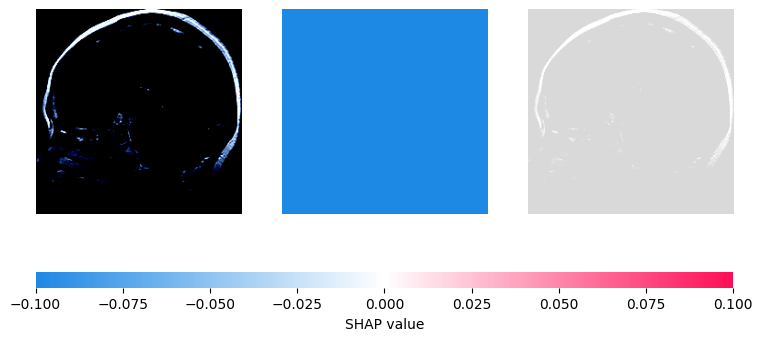

In [92]:
print("Local heatmap min/max:", np.min(local_heatmap), np.max(local_heatmap), "nan?", np.isnan(local_heatmap).any())
print("Global heatmap min/max:", np.min(global_heatmap), np.max(global_heatmap), "nan?", np.isnan(global_heatmap).any())


Local heatmap min/max: -0.0451692268193498 0.06722179489971929 nan? False
Global heatmap min/max: -0.0003720548812283355 0.0005790223440069494 nan? False


## SHAP OF LOCAL FED AVG AND GLOBAL FED AVG

Original SHAP shape: (1, 3, 224, 224, 4)
Final SHAP shape: (1, 224, 224, 3)
Original SHAP shape: (1, 3, 224, 224, 4)
Final SHAP shape: (1, 224, 224, 3)
Local heatmap min/max: -0.0451692268193498 0.06722179489971929
Global heatmap min/max: -0.0003720548812283355 0.0005790223440069494
🔍 SHAP Comparison: Local vs Global Model on Same Local Image


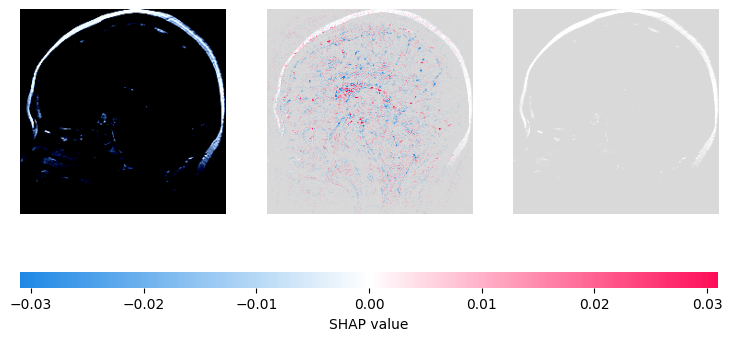

In [91]:
import shap
import numpy as np
import torch
import matplotlib.pyplot as plt

# ----- 1. Load one image from client k's local test set -----
k = 0  # client ID
image, label = next(iter(client_loaders[k]["test"]))
input_image = image[0].unsqueeze(0).to(DEVICE)  # Shape: (1, 3, 224, 224)

# ----- 2. Load Local and Global Models -----
local_model = create_resnet18(NUM_CLASSES, imagenet_init=False, freeze=False).to(DEVICE)
local_model.load_state_dict(local_results[k]["state_dict"])
local_model.eval()

global_model.eval()  # assume already loaded and on DEVICE

# ----- 3. Prepare background batch (10 samples from training data) -----
background_batch = []
for i in range(10):
    img, _ = train_full[i]  # assuming train_full is your training dataset
    background_batch.append(train_tf(img).unsqueeze(0))  # apply training transforms
background = torch.cat(background_batch, dim=0).to(DEVICE)  # shape (10, 3, 224, 224)

# ----- 4. Create SHAP explainers with proper background -----
explainer_local = shap.GradientExplainer(local_model, background)
explainer_global = shap.GradientExplainer(global_model, background)

# ----- 5. Compute SHAP values -----
shap_vals_local = explainer_local.shap_values(input_image)
shap_vals_global = explainer_global.shap_values(input_image)

# ----- 6. Prepare the input image for display -----
input_image_np = input_image[0].permute(1, 2, 0).detach().cpu().numpy()  # (224, 224, 3)
input_image_np = np.clip(input_image_np, 0, 1).astype(np.float32)

# ----- 7. Handle SHAP values shapes -----
def process_shap_array(arr):
    arr = np.array(arr)
    print("Original SHAP shape:", arr.shape)
    if arr.ndim == 5:
        arr = arr[..., 0]   # select first class
        arr = arr.transpose(0, 2, 3, 1)
    elif arr.ndim == 4:
        arr = arr.transpose(0, 2, 3, 1)
    elif arr.ndim == 3:
        arr = arr.transpose(1, 2, 0)
        arr = arr[np.newaxis, ...]
    else:
        raise ValueError(f"Unhandled SHAP shape: {arr.shape}")
    print("Final SHAP shape:", arr.shape)
    return arr

shap_vals_local_proc = process_shap_array(shap_vals_local)
shap_vals_global_proc = process_shap_array(shap_vals_global)

# ----- 8. Remove batch axis from SHAP arrays and image -----
local_heatmap = shap_vals_local_proc[0]
global_heatmap = shap_vals_global_proc[0]
visual_image = input_image_np

# ----- 9. Check values for debugging -----
print("Local heatmap min/max:", np.min(local_heatmap), np.max(local_heatmap))
print("Global heatmap min/max:", np.min(global_heatmap), np.max(global_heatmap))

# ----- 10. Plot comparison -----
print("🔍 SHAP Comparison: Local vs Global Model on Same Local Image")
shap.image_plot([local_heatmap, global_heatmap], visual_image)


## shap for fed prox one round only 

Original SHAP shape: (1, 3, 224, 224, 4)
Final SHAP shape: (1, 224, 224, 3)
Original SHAP shape: (1, 3, 224, 224, 4)
Final SHAP shape: (1, 224, 224, 3)
Local heatmap min/max: -0.04777940710516317 0.06271351003293069
Global heatmap min/max: -0.002001505346146371 0.0032877559562480936
🔍 SHAP Comparison: Local FedProx vs Global FedProx Model


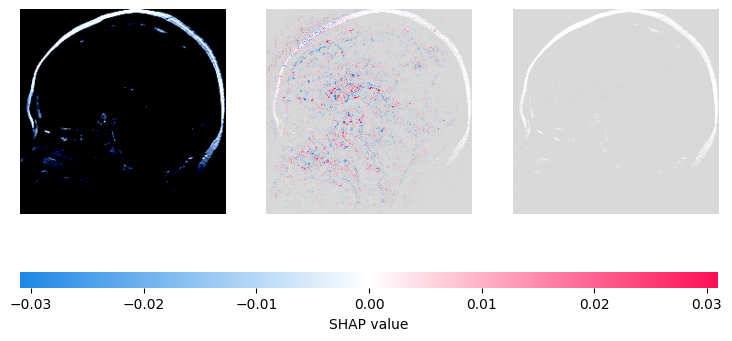

In [136]:
import shap
import numpy as np
import torch
import matplotlib.pyplot as plt


# ----- 1. Load one image from client k's local test set -----
k = 0  # client ID
image, label = next(iter(client_loaders[k]["test"]))
label = label[0].item()  # ← FIX: Convert tensor to int
input_image = image[0].unsqueeze(0).to(DEVICE)  # Shape: (1, 3, 224, 224)


# ----- 2. Load Local and Global Models -----
local_model = create_resnet18(NUM_CLASSES, imagenet_init=False, freeze=False).to(DEVICE)
local_model.load_state_dict(prox_results[k]["state_dict"])  # ← CHANGE: Use prox_results
local_model.eval()


global_model = prox_global_model  # ← CHANGE: Use prox_global_model directly
global_model.eval()


# ----- 3. Prepare background batch (10 samples from training data) -----
background_batch = []
for i in range(10):
    img, _ = train_full[i]
    background_batch.append(train_tf(img).unsqueeze(0))
background = torch.cat(background_batch, dim=0).to(DEVICE)


# ----- 4. Create SHAP explainers with proper background -----
explainer_local = shap.GradientExplainer(local_model, background)
explainer_global = shap.GradientExplainer(global_model, background)


# ----- 5. Compute SHAP values -----
shap_vals_local = explainer_local.shap_values(input_image)
shap_vals_global = explainer_global.shap_values(input_image)


# ----- 6. Prepare the input image for display -----
input_image_np = input_image[0].permute(1, 2, 0).detach().cpu().numpy()
input_image_np = np.clip(input_image_np, 0, 1).astype(np.float32)


# ----- 7. Handle SHAP values shapes -----
def process_shap_array(arr):
    arr = np.array(arr)
    print("Original SHAP shape:", arr.shape)
    if arr.ndim == 5:
        arr = arr[..., 0]
        arr = arr.transpose(0, 2, 3, 1)
    elif arr.ndim == 4:
        arr = arr.transpose(0, 2, 3, 1)
    elif arr.ndim == 3:
        arr = arr.transpose(1, 2, 0)
        arr = arr[np.newaxis, ...]
    else:
        raise ValueError(f"Unhandled SHAP shape: {arr.shape}")
    print("Final SHAP shape:", arr.shape)
    return arr


shap_vals_local_proc = process_shap_array(shap_vals_local)
shap_vals_global_proc = process_shap_array(shap_vals_global)


# ----- 8. Remove batch axis from SHAP arrays and image -----
local_heatmap = shap_vals_local_proc[0]
global_heatmap = shap_vals_global_proc[0]
visual_image = input_image_np


# ----- 9. Check values for debugging -----
print("Local heatmap min/max:", np.min(local_heatmap), np.max(local_heatmap))
print("Global heatmap min/max:", np.min(global_heatmap), np.max(global_heatmap))


# ----- 10. Plot comparison -----
print("🔍 SHAP Comparison: Local FedProx vs Global FedProx Model")
shap.image_plot([local_heatmap, global_heatmap], visual_image)


In [100]:
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import random
import numpy as np

# 🌱 Reproducibility
SEED = 77
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

# ⚙️ FedProx Config
NUM_ROUNDS = 20
LOCAL_EPOCHS = 2
FEDPROX_MU = 0.01
LR = 1e-4
NUM_CLIENTS = len(client_loaders)

# Freeze feature extractor in global model
for name, param in global_model.named_parameters():
    if "fc" not in name:
        param.requires_grad = False

# 📡 FedProx Rounds
for rnd in range(NUM_ROUNDS):
    print(f"\n🔁 Round {rnd+1}/{NUM_ROUNDS}")
    local_weights = []

    for k in range(NUM_CLIENTS):
        print(f"  🧠 Client {k} training...")
        local_model = copy.deepcopy(global_model)
        local_model.train()

        # Freeze base again (to be safe)
        for name, param in local_model.named_parameters():
            if "fc" not in name:  # Freeze everything except classifier
                param.requires_grad = False

        # Train only the classifier head
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, local_model.parameters()), lr=LR)

        # Local training loop
        for epoch in range(LOCAL_EPOCHS):
            for data, target in client_loaders[k]['train']:
                data, target = data.to(DEVICE), target.to(DEVICE)
                optimizer.zero_grad()

                output = local_model(data)
                ce_loss = nn.CrossEntropyLoss()(output, target)

                # FedProx loss: proximal term between local and global weights
                prox_term = 0.0
                for w, w_t in zip(local_model.parameters(), global_model.parameters()):
                    if w.requires_grad:
                        prox_term += ((w - w_t.detach()) ** 2).sum()
                loss = ce_loss + (FEDPROX_MU / 2) * prox_term

                loss.backward()
                optimizer.step()

        # Save local model state dict
        local_weights.append(copy.deepcopy(local_model.state_dict()))

    # 🧮 Aggregate with FedAvg (INDENTED INSIDE ROUND LOOP)
    new_state_dict = copy.deepcopy(global_model.state_dict())
    for key in new_state_dict.keys():
        stacked = torch.stack([local_weights[i][key] for i in range(NUM_CLIENTS)])
        if stacked.dtype in [torch.float32, torch.float64, torch.float16]:
            new_state_dict[key] = stacked.mean(0)
        else:
            # For int types (like num_batches_tracked), take it from one client
            new_state_dict[key] = local_weights[0][key]

    global_model.load_state_dict(new_state_dict)

    # 💾 Save model after this round (INDENTED INSIDE ROUND LOOP)
    print(f"🛠 Updating global model weights at round {rnd+1}")
    torch.save(global_model.state_dict(), f"fedprox_global_round_{rnd+1}.pth")
    print(f"✅ Saved: fedprox_global_round_{rnd+1}.pth")

    # Optional: Evaluate global model (INDENTED INSIDE ROUND LOOP)
    holdout_metrics = evaluate_basic(global_model, holdout_loader, DEVICE)
    print(f"🌍 Round {rnd+1} — Holdout Acc: {holdout_metrics['acc']:.3f}, Loss: {holdout_metrics['loss']:.4f}")



🔁 Round 1/20
  🧠 Client 0 training...
  🧠 Client 1 training...
  🧠 Client 2 training...
  🧠 Client 3 training...
🛠 Updating global model weights at round 1
✅ Saved: fedprox_global_round_1.pth
🌍 Round 1 — Holdout Acc: 0.673, Loss: 0.8123

🔁 Round 2/20
  🧠 Client 0 training...
  🧠 Client 1 training...
  🧠 Client 2 training...
  🧠 Client 3 training...
🛠 Updating global model weights at round 2
✅ Saved: fedprox_global_round_2.pth
🌍 Round 2 — Holdout Acc: 0.719, Loss: 0.5007

🔁 Round 3/20
  🧠 Client 0 training...
  🧠 Client 1 training...
  🧠 Client 2 training...
  🧠 Client 3 training...
🛠 Updating global model weights at round 3
✅ Saved: fedprox_global_round_3.pth
🌍 Round 3 — Holdout Acc: 0.831, Loss: 0.4107

🔁 Round 4/20
  🧠 Client 0 training...
  🧠 Client 1 training...
  🧠 Client 2 training...
  🧠 Client 3 training...
🛠 Updating global model weights at round 4
✅ Saved: fedprox_global_round_4.pth
🌍 Round 4 — Holdout Acc: 0.857, Loss: 0.3734

🔁 Round 5/20
  🧠 Client 0 training...
  🧠 Clien

In [101]:
# Load best global model
global_model.load_state_dict(torch.load("fedprox_global_round_20.pth"))
global_model.eval()

# Evaluate
metrics = evaluate_basic(global_model, holdout_loader, DEVICE)
print(f"📊 Final Evaluation — Accuracy: {metrics['acc']:.3f}, Loss: {metrics['loss']:.4f}")


📊 Final Evaluation — Accuracy: 0.895, Loss: 0.2844


In [102]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np
import torch


In [103]:
def evaluate_metrics(model, dataloader, device, num_classes):
    model.eval()
    all_preds = []
    all_probs = []
    all_targets = []

    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            probs = torch.softmax(output, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    # Convert to numpy arrays
    y_true = np.array(all_targets)
    y_pred = np.array(all_preds)
    y_prob = np.array(all_probs)

    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average='weighted', zero_division=0),
        "recall": recall_score(y_true, y_pred, average='weighted', zero_division=0),
        "f1": f1_score(y_true, y_pred, average='weighted', zero_division=0),
        "confusion_matrix": confusion_matrix(y_true, y_pred)
    }

    # Handle AUROC
    if num_classes == 2:
        # Binary case: use probs for class 1
        metrics["auroc"] = roc_auc_score(y_true, y_prob[:, 1])
    else:
        try:
            metrics["auroc"] = roc_auc_score(y_true, y_prob, multi_class='ovr', average='weighted')
        except ValueError:
            metrics["auroc"] = None  # AUROC may fail if only 1 class present in y_true

    return metrics


In [105]:
NUM_CLASSES = 4  # Change if using multi-class

# 🧠 Load final global model
global_model.load_state_dict(torch.load("fedprox_global_round_20.pth"))
global_model.to(DEVICE)

# 📦 Evaluate on Holdout
print("\n📦 Holdout Set Metrics:")
holdout_metrics = evaluate_metrics(global_model, holdout_loader, DEVICE, NUM_CLASSES)
for k, v in holdout_metrics.items():
    if k != "confusion_matrix":
        print(f"{k.capitalize()}: {v:.4f}")
print("Confusion Matrix:\n", holdout_metrics["confusion_matrix"])

# 👥 Evaluate on Clients
print("\n👤 Client Test Set Metrics:")
client_metrics = []
for k in range(NUM_CLIENTS):
    print(f"\nClient {k}:")
    metrics = evaluate_metrics(global_model, client_loaders[k]["test"], DEVICE, NUM_CLASSES)
    client_metrics.append(metrics)
    for key, val in metrics.items():
        if key != "confusion_matrix":
            if val is not None:
                print(f"{key.capitalize()}: {val:.4f}")
            else:
                print(f"{key.capitalize()}: None")
    print("Confusion Matrix:\n", metrics["confusion_matrix"])



📦 Holdout Set Metrics:
Accuracy: 0.8947
Precision: 0.8989
Recall: 0.8947
F1: 0.8957
Auroc: 0.9843
Confusion Matrix:
 [[261  38   0   1]
 [  8 261  23  14]
 [  7   8 390   0]
 [  7  32   0 261]]

👤 Client Test Set Metrics:

Client 0:
Accuracy: 0.9344
Precision: 0.9364
Recall: 0.9344
F1: 0.9350
Auroc: 0.9930
Confusion Matrix:
 [[ 74   2   0   2]
 [  1  49   3   4]
 [  2   1  99   1]
 [  5   9   0 205]]

Client 1:
Accuracy: 0.9219
Precision: 0.9257
Recall: 0.9219
F1: 0.9231
Auroc: 0.9890
Confusion Matrix:
 [[123  10   1   0]
 [  1  34   3   3]
 [  2   0  67   1]
 [  1   2   1  71]]

Client 2:
Accuracy: 0.9607
Precision: 0.9887
Recall: 0.9607
F1: 0.9739
Auroc: None
Confusion Matrix:
 [[  1   0   0   0]
 [  0  70   1   5]
 [  1   1 149   1]
 [  0   0   0   0]]

Client 3:
Accuracy: 0.8986
Precision: 0.9761
Recall: 0.8986
F1: 0.9357
Auroc: None
Confusion Matrix:
 [[56  3  0  1]
 [ 0 68  6  4]
 [ 0  0  0  0]
 [ 0  0  0  0]]


In [119]:
# 🔁 Convert FedProx Round 20 metrics to DataFrame format
rows = []
for client_id, metrics in enumerate(client_metrics):
    for metric_name in ["accuracy", "precision", "recall", "f1"]:
        rows.append({
            "Client": client_id,
            "Metric": metric_name.capitalize(),
            "FedProx_Round20": metrics[metric_name]
        })

df_fedprox20 = pd.DataFrame(rows)


🔍 SHAP Comparison: FedProx Global Model vs. Original Local Model on Same Image


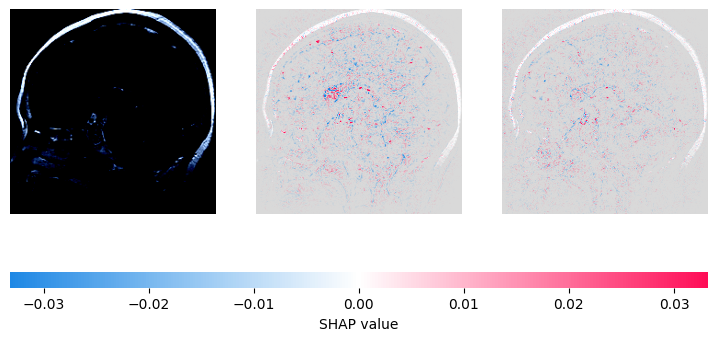

In [109]:
import shap
import numpy as np
import torch
import matplotlib.pyplot as plt

# ----- CONFIG -----
client_id = 0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_SAMPLES_BG = 10  # background size for SHAP

# ----- 1. Load one test image from Client -----
image, label = next(iter(client_loaders[client_id]["test"]))
input_image = image[0].unsqueeze(0).to(DEVICE)  # shape: (1, 3, 224, 224)

# ----- 2. Load FedProx Global Model -----
global_model = create_resnet18(NUM_CLASSES, imagenet_init=False, freeze=False).to(DEVICE)
global_model.load_state_dict(torch.load("fedprox_global_round_20.pth"))
global_model.eval()

# ----- 3. Load Client's Original Local Model (Before Fine-tuning) -----
local_model = create_resnet18(NUM_CLASSES, imagenet_init=False, freeze=False).to(DEVICE)
local_model.load_state_dict(torch.load(f"client_models/client_{client_id}_best_model.pth"))
local_model.eval()

# ----- 4. Create SHAP background -----
background_batch = []
for i in range(NUM_SAMPLES_BG):
    img, _ = train_full[i]  # raw PIL image from training dataset
    background_batch.append(train_tf(img).unsqueeze(0))  # apply training transforms
background = torch.cat(background_batch, dim=0).to(DEVICE)  # shape: (10, 3, 224, 224)

# ----- 5. Create SHAP explainers -----
explainer_global = shap.GradientExplainer(global_model, background)
explainer_local = shap.GradientExplainer(local_model, background)

# ----- 6. Compute SHAP values -----
shap_vals_global = explainer_global.shap_values(input_image)
shap_vals_local = explainer_local.shap_values(input_image)

# ----- 7. Process SHAP arrays for visualization -----
def process_shap_array(arr):
    arr = np.array(arr)
    if arr.ndim == 5:
        arr = arr[..., 0]   # class 0
        arr = arr.transpose(0, 2, 3, 1)
    elif arr.ndim == 4:
        arr = arr.transpose(0, 2, 3, 1)
    elif arr.ndim == 3:
        arr = arr.transpose(1, 2, 0)
        arr = arr[np.newaxis, ...]
    else:
        raise ValueError(f"Unhandled SHAP shape: {arr.shape}")
    return arr

shap_vals_global_proc = process_shap_array(shap_vals_global)
shap_vals_local_proc = process_shap_array(shap_vals_local)

# ----- 8. Prepare image for plotting -----
input_image_np = input_image[0].permute(1, 2, 0).detach().cpu().numpy()
input_image_np = np.clip(input_image_np, 0, 1).astype(np.float32)

# ----- 9. Plot SHAP side-by-side -----
print("🔍 SHAP Comparison: FedProx Global Model vs. Original Local Model on Same Image")
shap.image_plot([shap_vals_local_proc[0], shap_vals_global_proc[0]], input_image_np)


In [110]:
import torch
import torch.nn as nn
import torch.optim as optim
import copy

# 📌 CONFIG
NUM_EPOCHS_FINE = 3         # You can increase for stronger personalization
LR_FINE = 1e-4              # Fine-tuning learning rate
client_personalized_models = {}

# 📦 Load final global model
global_weights = torch.load("fedprox_global_round_20.pth")

# 🔁 Fine-tune on each client
for k in range(NUM_CLIENTS):
    print(f"\n🎯 Fine-tuning Client {k} on local data...")

    # Clone global model
    local_model = create_resnet18(NUM_CLASSES, imagenet_init=False, freeze=False).to(DEVICE)
    local_model.load_state_dict(global_weights)
    
    # Only fine-tune the classifier head
    for name, param in local_model.named_parameters():
        if "fc" not in name:
            param.requires_grad = False

    local_model.train()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, local_model.parameters()), lr=LR_FINE)

    for epoch in range(NUM_EPOCHS_FINE):
        for data, target in client_loaders[k]["train"]:
            data, target = data.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            output = local_model(data)
            loss = nn.CrossEntropyLoss()(output, target)
            loss.backward()
            optimizer.step()
    
    # Save personalized model
    client_personalized_models[k] = copy.deepcopy(local_model.state_dict())
    torch.save(local_model.state_dict(), f"client_{k}_fedprox_personalized.pth")
    print(f"✅ Saved personalized model for Client {k}")



🎯 Fine-tuning Client 0 on local data...
✅ Saved personalized model for Client 0

🎯 Fine-tuning Client 1 on local data...
✅ Saved personalized model for Client 1

🎯 Fine-tuning Client 2 on local data...
✅ Saved personalized model for Client 2

🎯 Fine-tuning Client 3 on local data...
✅ Saved personalized model for Client 3


In [112]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import torch.nn.functional as F

def evaluate_metrics(model, dataloader):
    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            probs = F.softmax(output, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    acc = accuracy_score(all_targets, all_preds)
    prec = precision_score(all_targets, all_preds, average='weighted', zero_division=0)
    rec = recall_score(all_targets, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_targets, all_preds, average='weighted', zero_division=0)
    
    try:
        auroc = roc_auc_score(all_targets, probs.cpu().numpy(), multi_class='ovr')
    except:
        auroc = None

    cm = confusion_matrix(all_targets, all_preds)

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "auroc": auroc,
        "confusion_matrix": cm
    }

# 🧪 Evaluate all personalized models
for k in range(NUM_CLIENTS):
    print(f"\n🧠 Client {k} Personalized Model Evaluation:")

    # Load personalized model
    model = create_resnet18(NUM_CLASSES, imagenet_init=False, freeze=False).to(DEVICE)
    model.load_state_dict(torch.load(f"client_{k}_fedprox_personalized.pth"))
    model.eval()

    # Local test
    local_metrics = evaluate_metrics(model, client_loaders[k]["test"])
    print("📍 Local Test Set:")
    for key, val in local_metrics.items():
        if key != "confusion_matrix":
            if val is not None:
                print(f"  {key.capitalize()}: {val:.4f}")
            else:
                print(f"  {key.capitalize()}: N/A")

    print("  Confusion Matrix:\n", local_metrics["confusion_matrix"])

    # Holdout test
    holdout_metrics = evaluate_metrics(model, holdout_loader)
    print("🌍 Holdout Test Set:")
    for key, val in holdout_metrics.items():
        if key != "confusion_matrix":
            if val is not None:
                print(f"  {key.capitalize()}: {val:.4f}")
            else:
                print(f"  {key.capitalize()}: N/A")
    print("  Confusion Matrix:\n", holdout_metrics["confusion_matrix"])



🧠 Client 0 Personalized Model Evaluation:
📍 Local Test Set:
  Accuracy: 0.9475
  Precision: 0.9485
  Recall: 0.9475
  F1: 0.9464
  Auroc: N/A
  Confusion Matrix:
 [[ 75   1   0   2]
 [  3  44   2   8]
 [  2   1  99   1]
 [  4   0   0 215]]
🌍 Holdout Test Set:
  Accuracy: 0.9123
  Precision: 0.9139
  Recall: 0.9123
  F1: 0.9105
  Auroc: N/A
  Confusion Matrix:
 [[287   9   0   4]
 [ 12 233  25  36]
 [  8   5 388   4]
 [  8   4   0 288]]

🧠 Client 1 Personalized Model Evaluation:
📍 Local Test Set:
  Accuracy: 0.9406
  Precision: 0.9395
  Recall: 0.9406
  F1: 0.9395
  Auroc: N/A
  Confusion Matrix:
 [[131   3   0   0]
 [  2  31   2   6]
 [  1   0  68   1]
 [  1   2   1  71]]
🌍 Holdout Test Set:
  Accuracy: 0.9123
  Precision: 0.9118
  Recall: 0.9123
  F1: 0.9113
  Auroc: N/A
  Confusion Matrix:
 [[288  10   0   2]
 [ 16 245  24  21]
 [  8   8 389   0]
 [ 11  15   0 274]]

🧠 Client 2 Personalized Model Evaluation:
📍 Local Test Set:
  Accuracy: 0.9607
  Precision: 0.9735
  Recall: 0.9607
 

In [115]:
import pandas as pd

# Placeholder lists to collect metrics
rows = []

# Loop over all clients
for k in range(NUM_CLIENTS):
    print(f"\n📊 Evaluating Client {k}...")

    # ----- Load FedProx Global Model -----
    global_model = create_resnet18(NUM_CLASSES, imagenet_init=False, freeze=False).to(DEVICE)
    global_model.load_state_dict(torch.load("fedprox_global_round_20.pth"))  # adjust if your last global
    global_model.eval()
    global_metrics = evaluate_metrics(global_model, client_loaders[k]["test"])

    # ----- Load Personalized Model -----
    personal_model = create_resnet18(NUM_CLASSES, imagenet_init=False, freeze=False).to(DEVICE)
    personal_model.load_state_dict(torch.load(f"client_{k}_fedprox_personalized.pth"))
    personal_model.eval()
    personal_metrics = evaluate_metrics(personal_model, client_loaders[k]["test"])

    # ----- Store in comparison table -----
    for metric in ["accuracy", "precision", "recall", "f1", "auroc"]:
        g_val = global_metrics[metric]
        p_val = personal_metrics[metric]
        rows.append({
            "Client": k,
            "Metric": metric.capitalize(),
            "FedProx_Global": round(g_val, 4) if g_val is not None else "N/A",
            "Personalized": round(p_val, 4) if p_val is not None else "N/A"
        })

# Create DataFrame
df_comparison = pd.DataFrame(rows)

# Display side-by-side view
df_comparison  # Just this line at the end of the cell



📊 Evaluating Client 0...

📊 Evaluating Client 1...

📊 Evaluating Client 2...

📊 Evaluating Client 3...


,Client,Metric,FedProx_Global,Personalized
0,0,Accuracy,0.9344,0.9475
1,0,Precision,0.9364,0.9485
2,0,Recall,0.9344,0.9475
3,0,F1,0.935,0.9464
4,0,Auroc,N/A,N/A
5,1,Accuracy,0.9219,0.9406
6,1,Precision,0.9257,0.9395
7,1,Recall,0.9219,0.9406
8,1,F1,0.9231,0.9395
9,1,Auroc,N/A,N/A


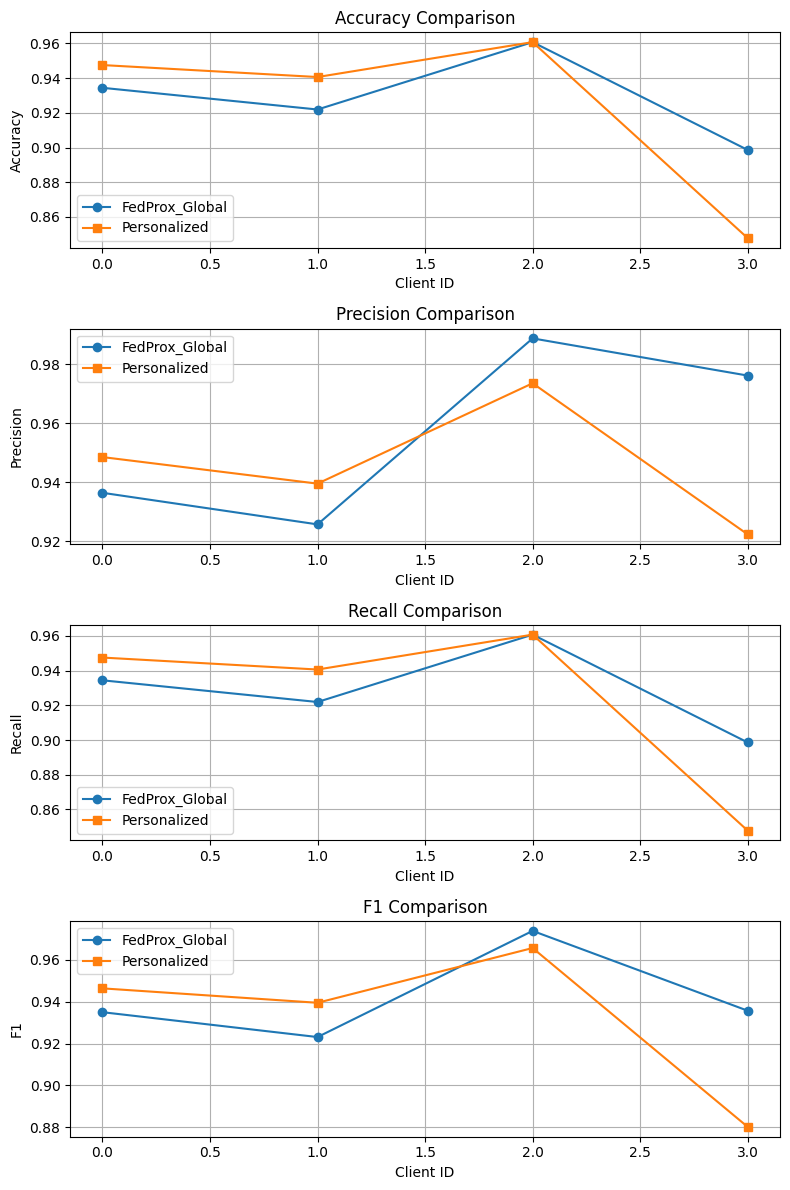

In [118]:
import matplotlib.pyplot as plt
import pandas as pd

# Recreate the metric table from the screenshot
data = {
    "Client": [0]*4 + [1]*4 + [2]*4 + [3]*4,
    "Metric": ["Accuracy", "Precision", "Recall", "F1"] * 4,
    "FedProx_Global": [0.9344, 0.9364, 0.9344, 0.9350,
                       0.9219, 0.9257, 0.9219, 0.9231,
                       0.9607, 0.9887, 0.9607, 0.9739,
                       0.8986, 0.9761, 0.8986, 0.9357],
    "Personalized": [0.9475, 0.9485, 0.9475, 0.9464,
                     0.9406, 0.9395, 0.9406, 0.9395,
                     0.9607, 0.9735, 0.9607, 0.9657,
                     0.8478, 0.9223, 0.8478, 0.8801]
}

df = pd.DataFrame(data)

# Plotting
metrics = ["Accuracy", "Precision", "Recall", "F1"]
fig, axs = plt.subplots(len(metrics), 1, figsize=(8, 12))

for i, metric in enumerate(metrics):
    df_metric = df[df["Metric"] == metric]
    axs[i].plot(df_metric["Client"], df_metric["FedProx_Global"], label="FedProx_Global", marker='o')
    axs[i].plot(df_metric["Client"], df_metric["Personalized"], label="Personalized", marker='s')
    axs[i].set_title(f"{metric} Comparison")
    axs[i].set_xlabel("Client ID")
    axs[i].set_ylabel(metric)
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()


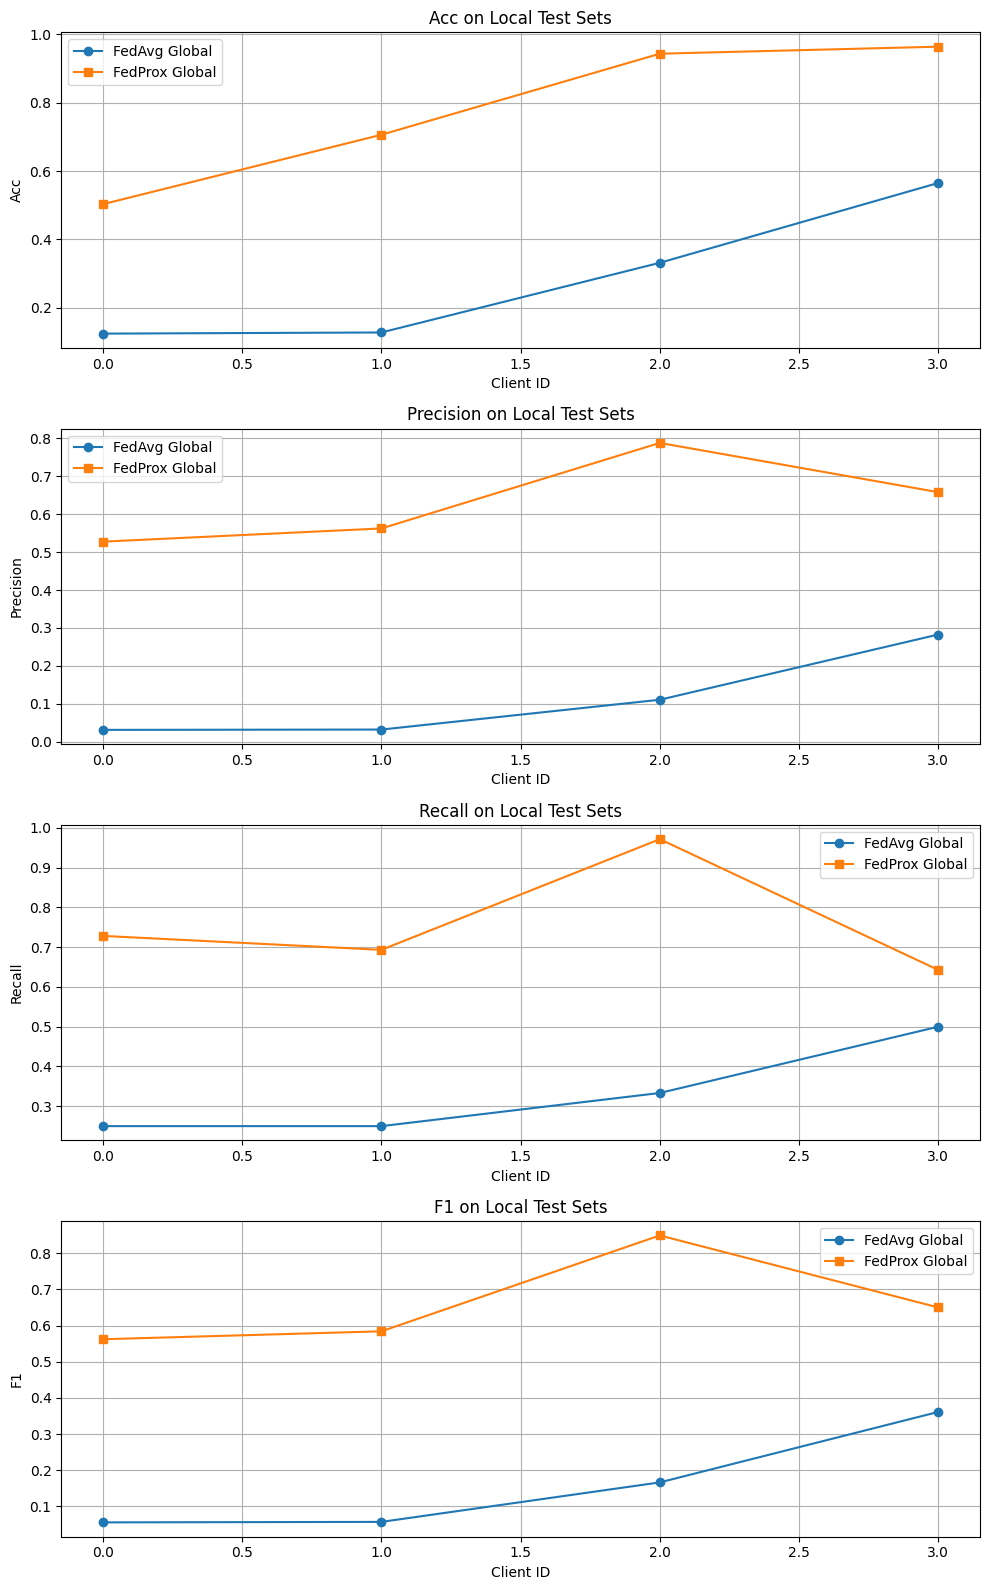

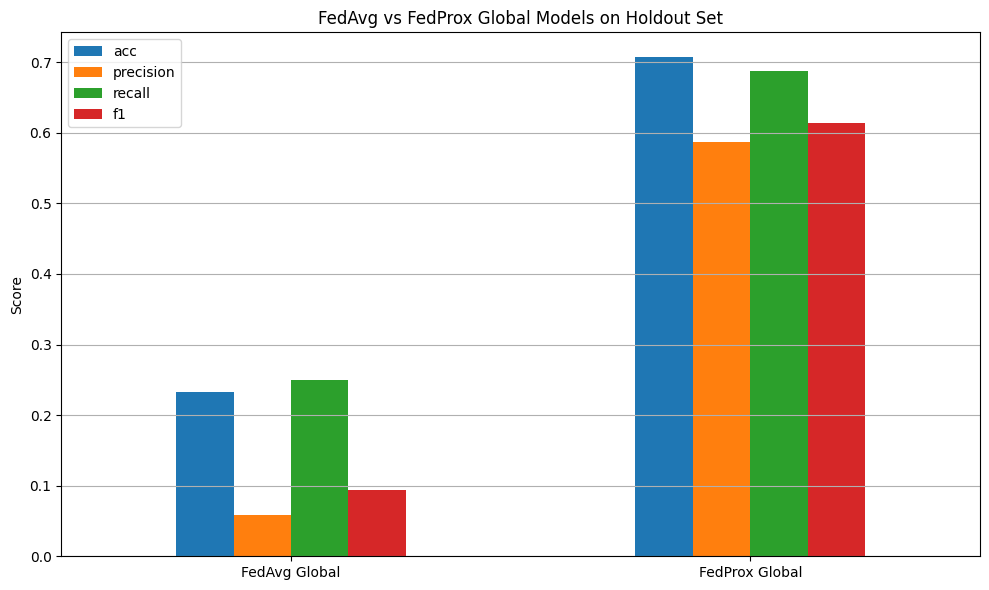

In [116]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. FedAvg vs FedProx Global on Clients' Local Test Sets
metrics = ['acc', 'precision', 'recall', 'f1']
fig, axes = plt.subplots(len(metrics), 1, figsize=(10, 16))
for i, metric in enumerate(metrics):
    axes[i].plot(df_fedavg_global_local.index, df_fedavg_global_local[metric], label="FedAvg Global", marker='o')
    axes[i].plot(df_fedprox_global_local.index, df_fedprox_global_local[metric], label="FedProx Global", marker='s')
    axes[i].set_title(f"{metric.capitalize()} on Local Test Sets")
    axes[i].set_xlabel("Client ID")
    axes[i].set_ylabel(metric.capitalize())
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()

# 2. FedAvg vs FedProx Global on Holdout Set
df_compare_holdout = pd.concat([df_fedavg_global_holdout, df_fedprox_global_holdout])
df_compare_holdout[metrics].plot(kind='bar', figsize=(10, 6))
plt.title("FedAvg vs FedProx Global Models on Holdout Set")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


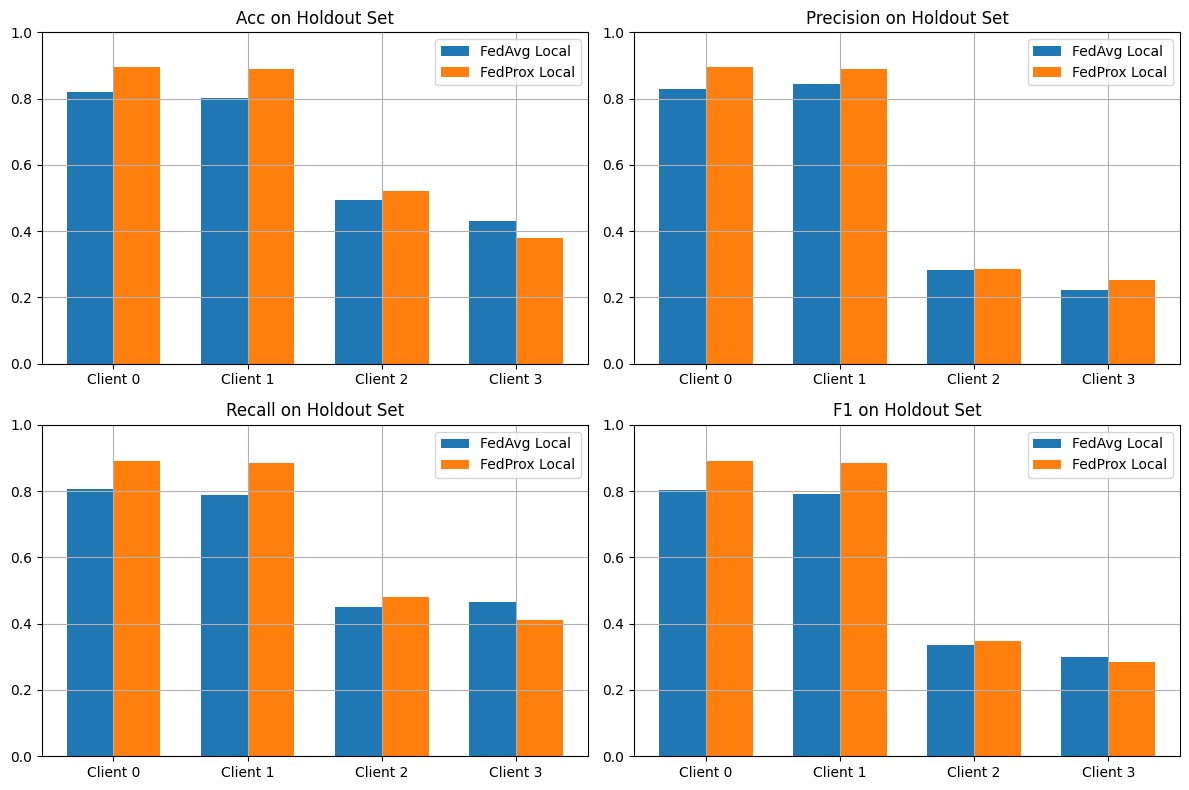

In [117]:
import matplotlib.pyplot as plt
import numpy as np

# Tables as dictionaries
fedavg_holdout = {
    0: {"acc": 0.8192, "precision": 0.8297, "recall": 0.8069, "f1": 0.8022},
    1: {"acc": 0.8032, "precision": 0.8444, "recall": 0.7898, "f1": 0.7913},
    2: {"acc": 0.4935, "precision": 0.2834, "recall": 0.4493, "f1": 0.3349},
    3: {"acc": 0.4317, "precision": 0.2219, "recall": 0.4669, "f1": 0.2988},
}

fedprox_holdout = {
    0: {"acc": 0.8947, "precision": 0.8945, "recall": 0.8914, "f1": 0.8901},
    1: {"acc": 0.8894, "precision": 0.8907, "recall": 0.8863, "f1": 0.8837},
    2: {"acc": 0.5210, "precision": 0.2851, "recall": 0.4797, "f1": 0.3466},
    3: {"acc": 0.3806, "precision": 0.2524, "recall": 0.4109, "f1": 0.2835},
}

metrics = ["acc", "precision", "recall", "f1"]
client_ids = list(fedavg_holdout.keys())
x = np.arange(len(client_ids))  # [0, 1, 2, 3]
width = 0.35

# Plot each metric
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

for i, metric in enumerate(metrics):
    fedavg_vals = [fedavg_holdout[c][metric] for c in client_ids]
    fedprox_vals = [fedprox_holdout[c][metric] for c in client_ids]

    ax = axs[i]
    ax.bar(x - width/2, fedavg_vals, width, label="FedAvg Local")
    ax.bar(x + width/2, fedprox_vals, width, label="FedProx Local")

    ax.set_title(f"{metric.capitalize()} on Holdout Set")
    ax.set_xticks(x)
    ax.set_xticklabels([f"Client {i}" for i in client_ids])
    ax.set_ylim(0, 1)
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


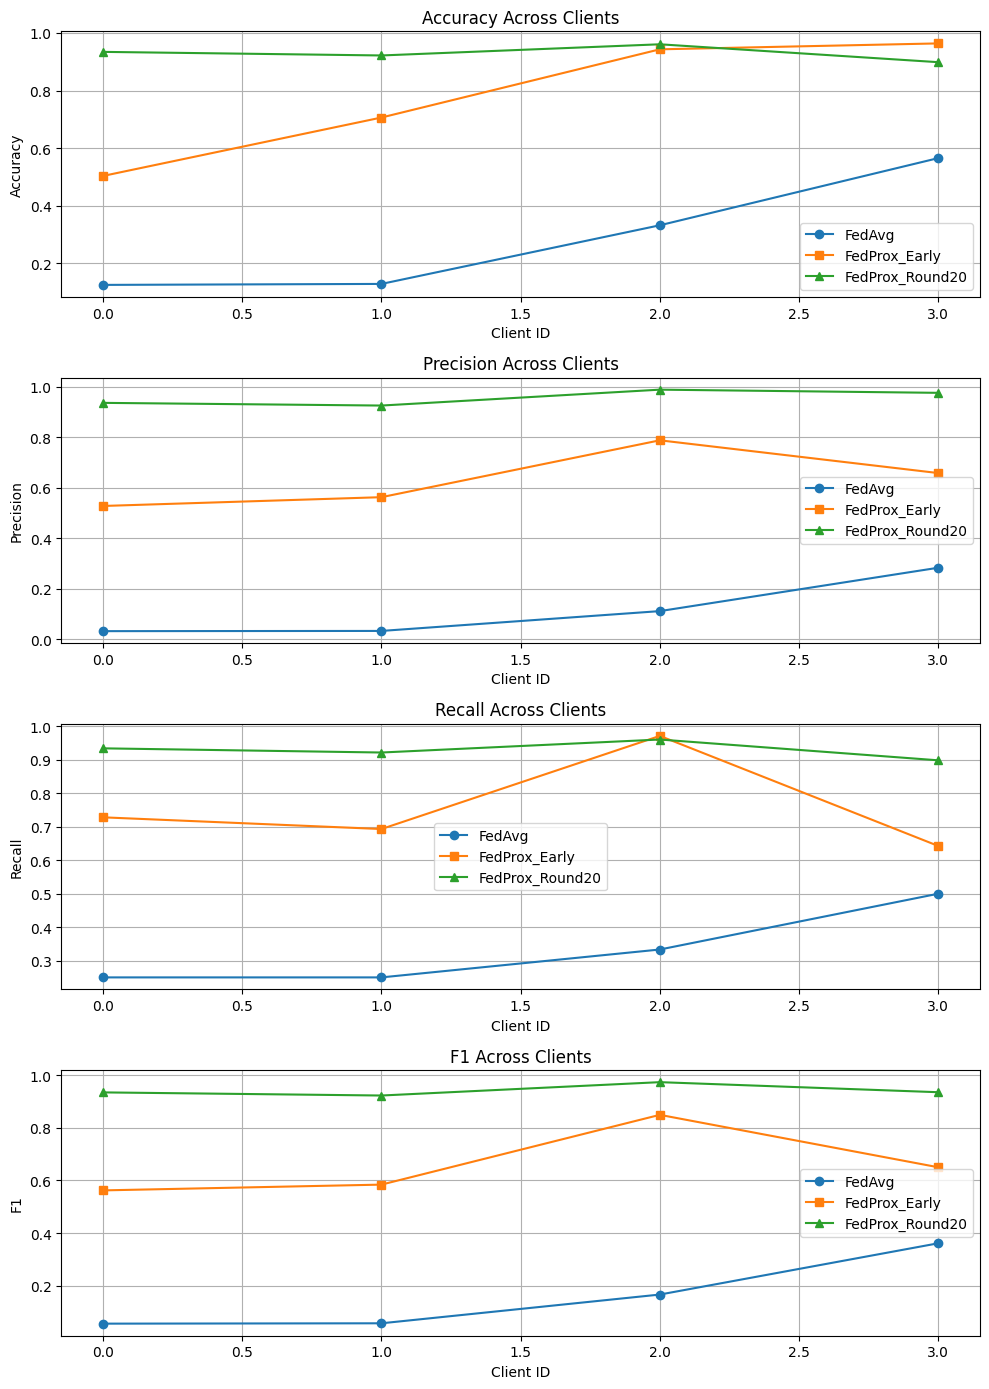

In [123]:
import matplotlib.pyplot as plt
import pandas as pd

# Consistent metric keys and display names
metrics_list = [
    ("acc", "Accuracy", "accuracy"),
    ("precision", "Precision", "precision"),
    ("recall", "Recall", "recall"),
    ("f1", "F1", "f1"),
]

# Build rows
rows = []
for k in range(NUM_CLIENTS):
    for fedprox_key, display_name, client_key in metrics_list:
        rows.append({
            "Client": k,
            "Metric": display_name,
            "FedAvg": fedavg_global_local_metrics[k][fedprox_key],
            "FedProx_Early": fedprox_global_local_metrics[k][fedprox_key],
            "FedProx_Round20": client_metrics[k][client_key]  # This is the different key!
        })

# Create DataFrame
df = pd.DataFrame(rows)

# Plotting
fig, axs = plt.subplots(len(metrics_list), 1, figsize=(10, 14))

for i, (_, metric_name, _) in enumerate(metrics_list):
    df_metric = df[df["Metric"] == metric_name]

    axs[i].plot(df_metric["Client"], df_metric["FedAvg"], label="FedAvg", marker='o')
    axs[i].plot(df_metric["Client"], df_metric["FedProx_Early"], label="FedProx_Early", marker='s')
    axs[i].plot(df_metric["Client"], df_metric["FedProx_Round20"], label="FedProx_Round20", marker='^')

    axs[i].set_title(f"{metric_name} Across Clients")
    axs[i].set_xlabel("Client ID")
    axs[i].set_ylabel(metric_name)
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()



In [122]:
print(fedavg_global_local_metrics[0].keys())


dict_keys(['acc', 'precision', 'recall', 'f1'])


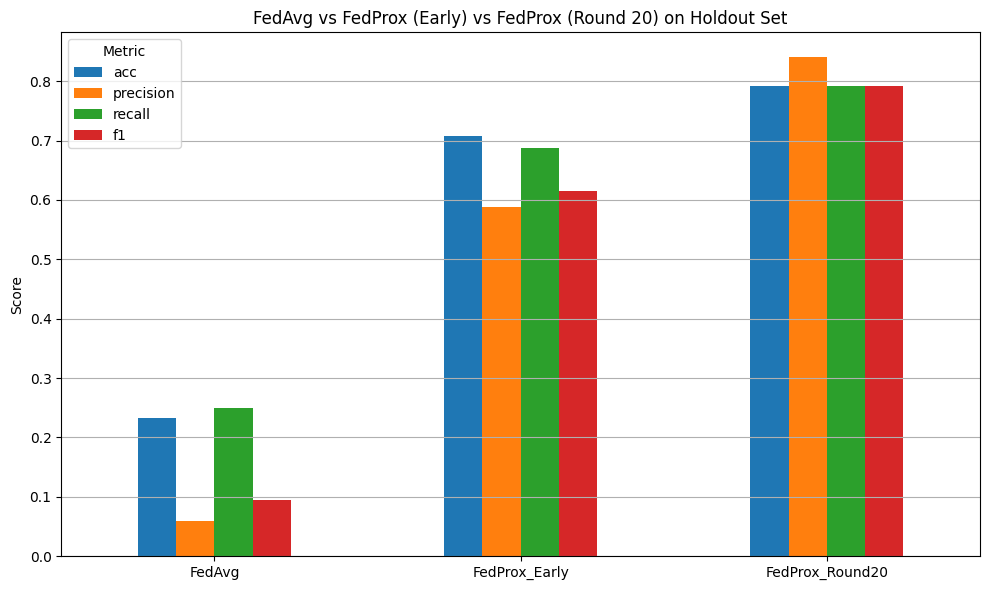

In [124]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Normalize all keys to same format
# (Assuming these are already defined in previous cells)
# fedavg_global_metrics, fedprox_global_metrics, holdout_metrics (from FedProx Round 20)

# If needed, map 'accuracy' -> 'acc' for consistency
fedprox_round20_holdout = {
    "acc": holdout_metrics["accuracy"],
    "precision": holdout_metrics["precision"],
    "recall": holdout_metrics["recall"],
    "f1": holdout_metrics["f1"]
}

# Step 2: Construct DataFrame
df_compare_holdout_all = pd.DataFrame([
    fedavg_global_metrics,           # Already uses 'acc', 'precision', etc.
    fedprox_global_metrics,          # Already uses 'acc', 'precision', etc.
    fedprox_round20_holdout          # Newly mapped
], index=["FedAvg", "FedProx_Early", "FedProx_Round20"])

# Step 3: Plot
df_compare_holdout_all[["acc", "precision", "recall", "f1"]].plot(kind='bar', figsize=(10, 6))

plt.title("FedAvg vs FedProx (Early) vs FedProx (Round 20) on Holdout Set")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(title="Metric")
plt.tight_layout()
plt.show()


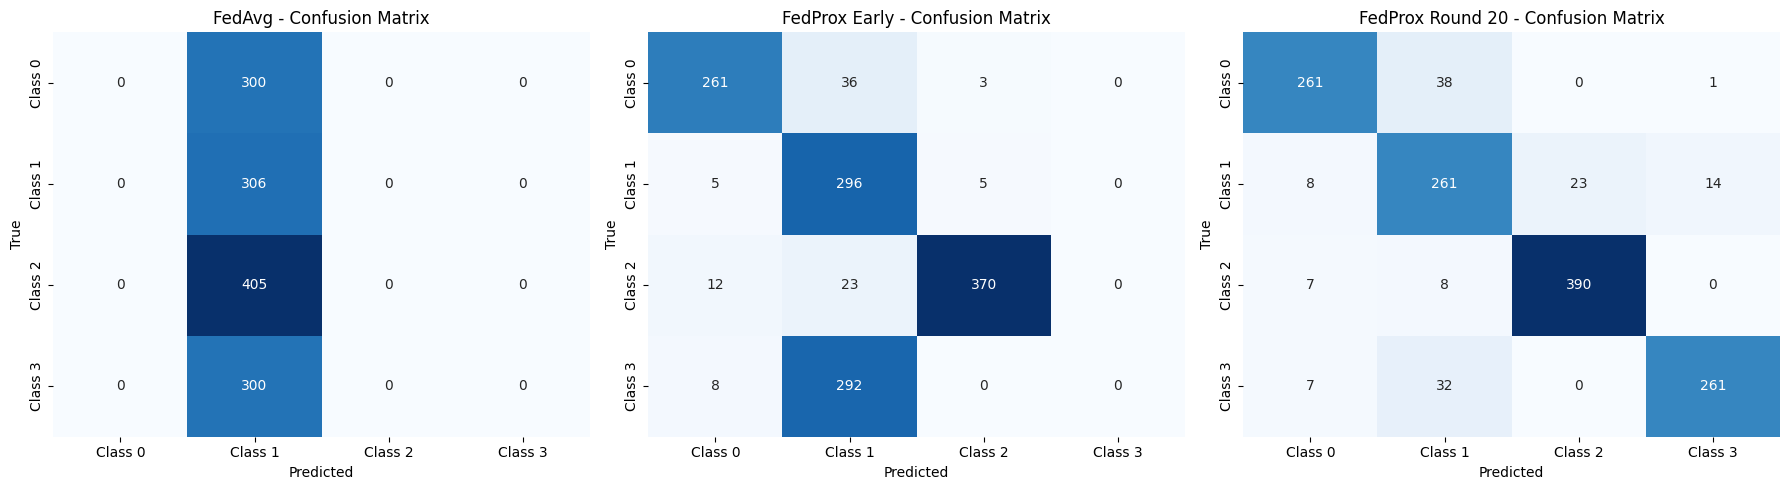

In [129]:
# Assuming:
# - FedAvg used `global_model` before FedProx started
# - FedProx early = `prox_global_model`
# - FedProx round 20 = `global_model` after loading final checkpoint

fedavg_model = fedavg_global_model         # replace with correct model if needed
fedprox_model = prox_global_model
fedprox_20_model = global_model            # after loading 20th round FedProx

# Now use the plotting code
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate and get confusion matrices
cm_fedavg = evaluate_metrics(fedavg_model, holdout_loader)["confusion_matrix"]
cm_fedprox = evaluate_metrics(fedprox_model, holdout_loader)["confusion_matrix"]
cm_fedprox20 = evaluate_metrics(fedprox_20_model, holdout_loader)["confusion_matrix"]

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
titles = ["FedAvg", "FedProx Early", "FedProx Round 20"]
cms = [cm_fedavg, cm_fedprox, cm_fedprox20]

for ax, cm, title in zip(axes, cms, titles):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=[f"Class {i}" for i in range(NUM_CLASSES)],
                yticklabels=[f"Class {i}" for i in range(NUM_CLASSES)],
                ax=ax)
    ax.set_title(f"{title} - Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.tight_layout()
plt.show()

